In [26]:
import os
import math

import matplotlib
import numpy as np
import sys
import yaml

sys.path.append('../')
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn.decomposition import PCA
from matplotlib import cm

from model import RecurrentNeuralNetwork
from posterior_inference_dataset import Posterior

%matplotlib inline

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
phi = np.linspace(-20, 20, 100)
np.mean(0.25 * np.exp(-(- phi) ** 2 / (2.0 * 5)))

0.034680883151462186

In [29]:
np.mean(1 * np.exp(-(0 - phi) ** 2 / (2.0 * 5)))

0.13872353260584874

In [30]:
def make_signal_cc_task(N, time_length, mu_min, mu_max, uncertainty,fix_input=False):
    input_signals = np.zeros([N, time_length, 200])
    phi = np.linspace(-20, 20, 100)
    sigma_sq = 5
    mu_post_list = []
    sigma_post_list = []
    for i in range(N):
        signal1_input = np.zeros([time_length, 100])
        signal2_input = np.zeros([time_length, 100])
        mu = np.random.rand() * (mu_max - mu_min) + mu_min
        # g_1, g_2 = np.random.choice([0.25, 0.5, 0.75, 1.0, 1.25], size=2)
        g_1, g_2 = np.random.rand(2) + 0.25
        signal1_base = g_1 * np.exp(-(mu - phi) ** 2 / (2.0 * sigma_sq))
        signal2_base = g_2 * np.exp(-(mu - phi) ** 2 / (2.0 * sigma_sq))
        for t in range(time_length):
            signal1_input[t] = np.random.poisson(signal1_base)
        for t in range(time_length):
            signal2_input[t] = np.random.poisson(signal2_base)
        if fix_input:
            tmp1 = np.random.poisson(signal1_base)
            tmp2 = np.random.poisson(signal2_base)
            for t in range(time_length):
                signal1_input[t] = tmp1
                signal2_input[t] = tmp2
            
        # target
        sigma_1 = np.sqrt(1 / g_1) * uncertainty
        sigma_2 = np.sqrt(1 / g_2) * uncertainty
        mu_posterior = ((sigma_1 ** 2) * mu +
                        (sigma_2 ** 2) * mu) / (sigma_1 ** 2 + sigma_2 ** 2)
        g_3 = g_1 + g_2
        sigma_posterior = np.sqrt(1 / g_3) * uncertainty
        
        input_signals[i] = np.concatenate((signal1_input, signal2_input), axis=1)
        
        mu_post_list.append(mu_posterior)
        sigma_post_list.append(sigma_posterior)

    return input_signals, mu_post_list, sigma_post_list

In [31]:
config_path = '../cfg/cue_combination_sampling/19_1.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

In [32]:
print(cfg['MODEL']['SIGMA_NEU'])

0


In [33]:
torch.manual_seed(1)
device = torch.device('cpu')

In [34]:
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

if 'ALPHA' not in cfg['MODEL'].keys():
    cfg['MODEL']['ALPHA'] = 0.25
    
# cfg['MODEL']['SIGMA_NEU'] = 0.05
cfg['DATALOADER']['TIME_LENGTH'] = 60

model = RecurrentNeuralNetwork(n_in=200, n_out=1, n_hid=cfg['MODEL']['SIZE'], device=device,
                               alpha_time_scale=cfg['MODEL']['ALPHA'], 
                               activation=cfg['MODEL']['ACTIVATION'],
                               sigma_neu=cfg['MODEL']['SIGMA_NEU'],
            
                               use_bias=cfg['MODEL']['USE_BIAS'],
        
                               ffnn=True).to(device)

model_path = f'../trained_model/cue_combination_sampling/{model_name}/epoch_1000.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

model_name:  19_1


RecurrentNeuralNetwork(
  (w_in): Linear(in_features=200, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
)

In [42]:
sample_num = 1000

outputs_np = np.zeros(sample_num)
input_signal, mu_post_list, sigma_post_list = make_signal_cc_task(sample_num, 
                                                                  time_length=cfg['DATALOADER']['TIME_LENGTH'], 
                                                                  mu_min=-20,
                                                                  mu_max=-20,
                                                                  uncertainty=cfg['DATALOADER']['UNCERTAINTY'],
                                                                  fix_input=False)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

In [43]:
neural_dynamics = np.zeros((sample_num, cfg['DATALOADER']['TIME_LENGTH'], model.n_hid))                                                                        

hidden_np = np.zeros((sample_num, cfg['MODEL']['SIZE']))
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                                             
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs, _ = model(inputs, hidden, cfg['DATALOADER']['TIME_LENGTH'])                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()                          
# outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
# neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

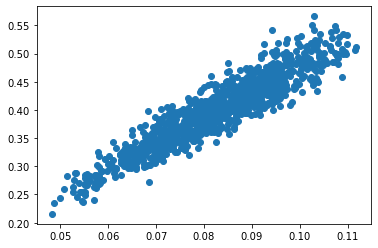

In [44]:
plt.scatter(
    np.mean(np.std(input_signal[:, :, :], axis=1), axis=1),
    np.mean(np.std(model.w_in(inputs).detach().numpy(), axis=1), axis=1),
)

plt.show()

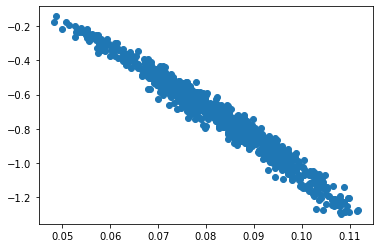

In [45]:
plt.scatter(
    np.mean(np.std(input_signal[:, :, :], axis=1), axis=1),
    np.mean(np.mean(model.w_in(inputs).detach().numpy(), axis=1), axis=1),
)

plt.show()

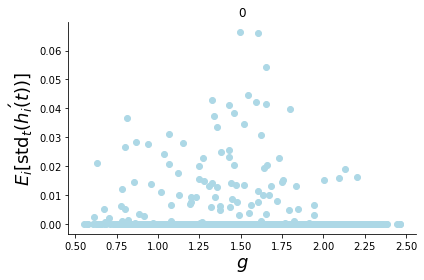

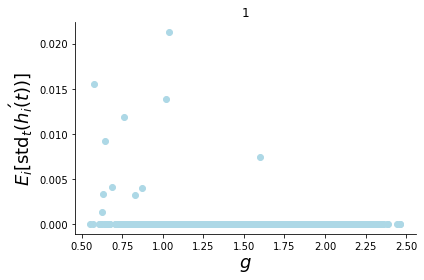

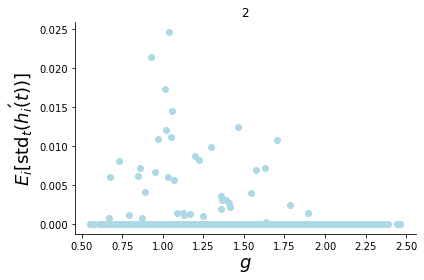

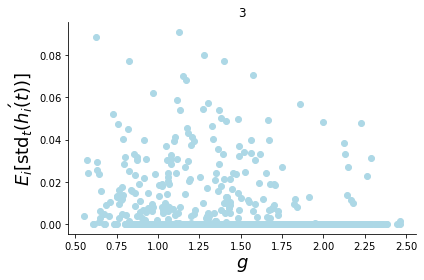

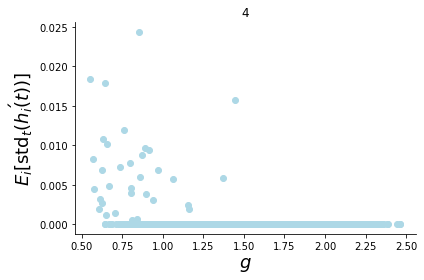

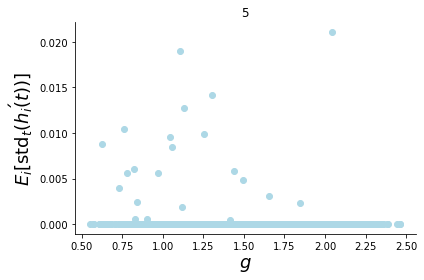

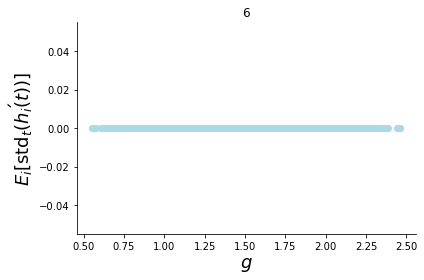

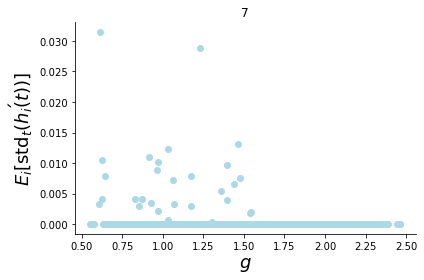

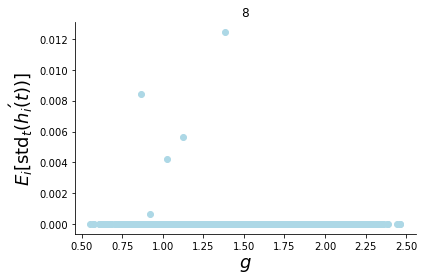

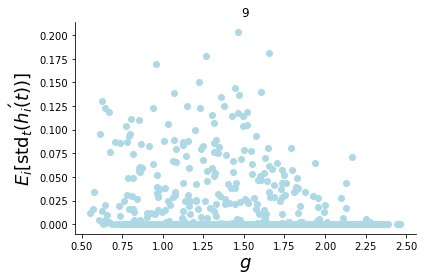

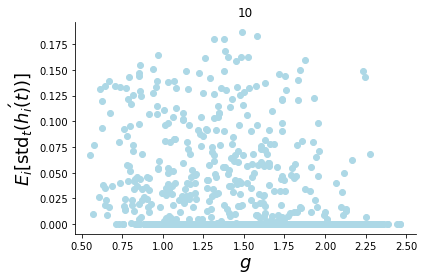

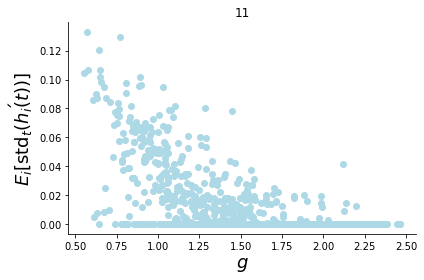

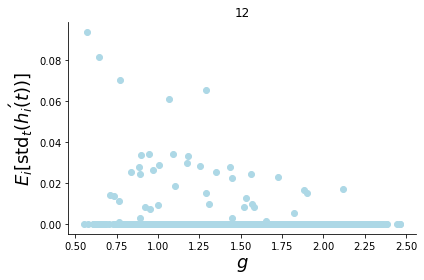

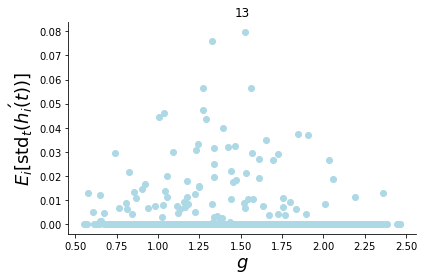

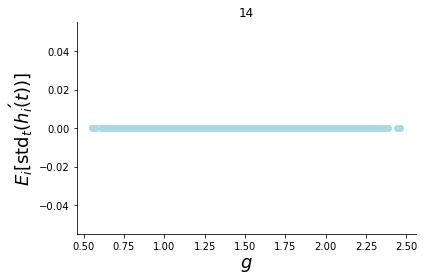

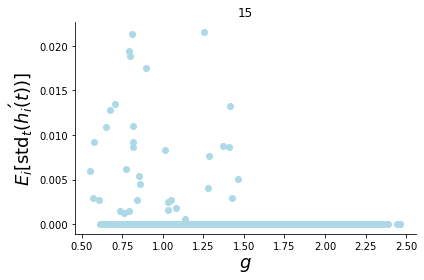

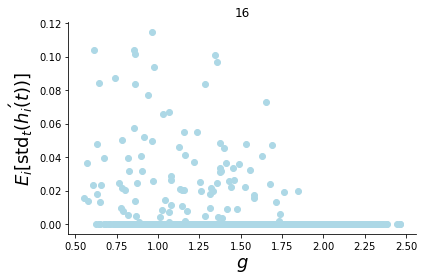

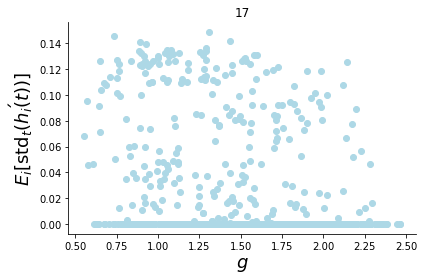

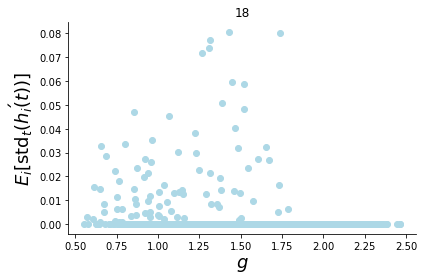

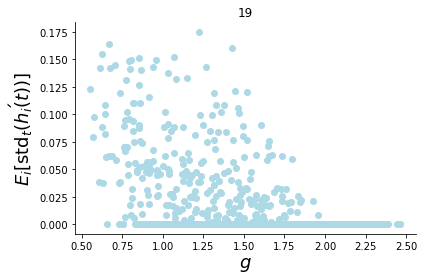

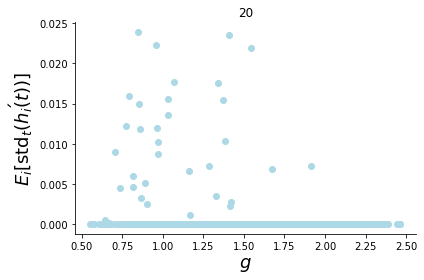

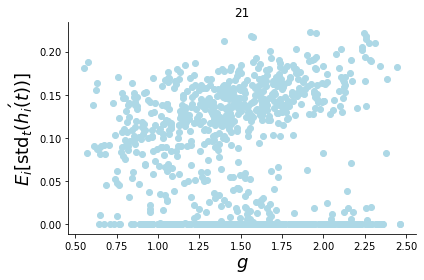

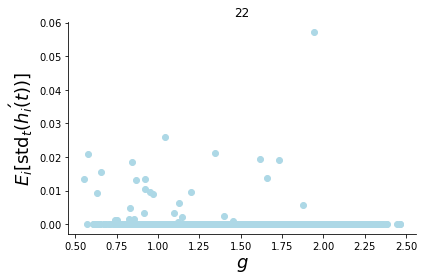

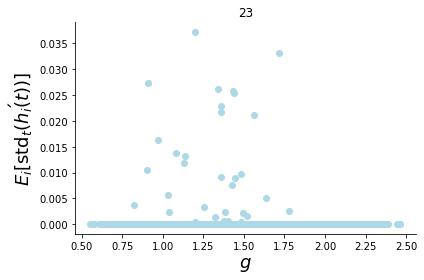

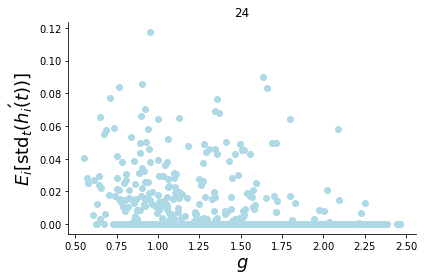

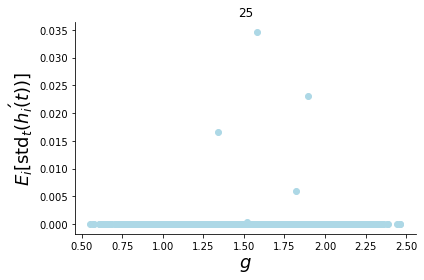

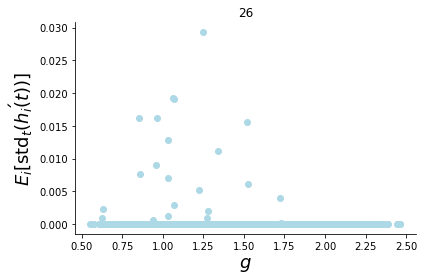

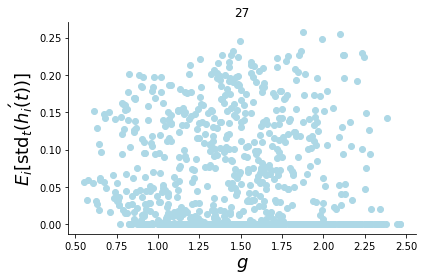

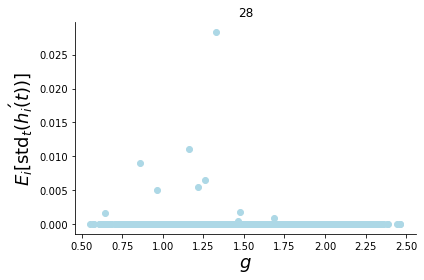

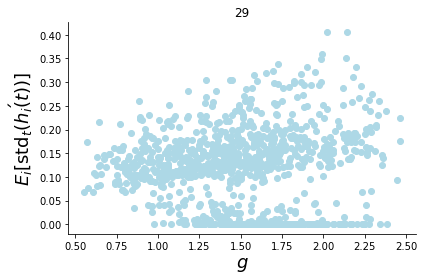

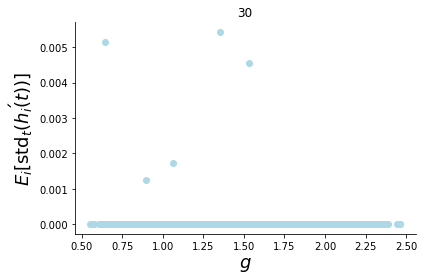

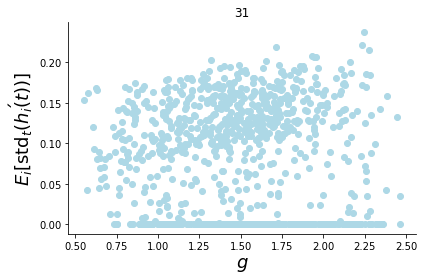

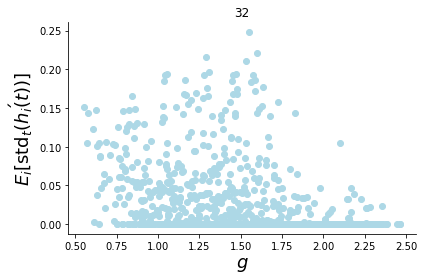

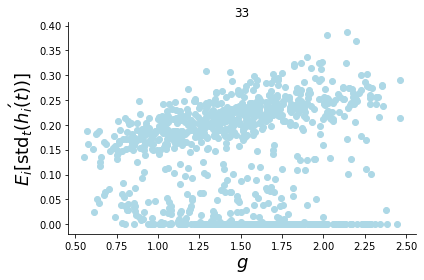

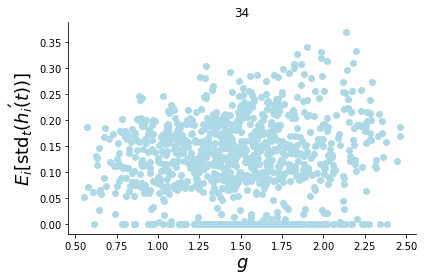

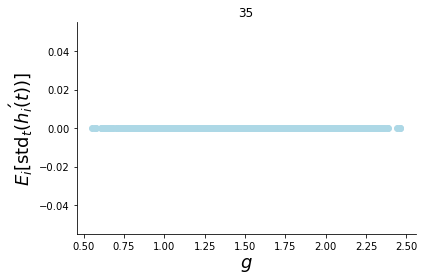

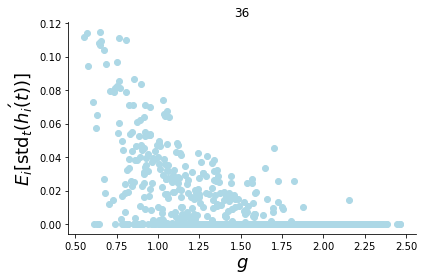

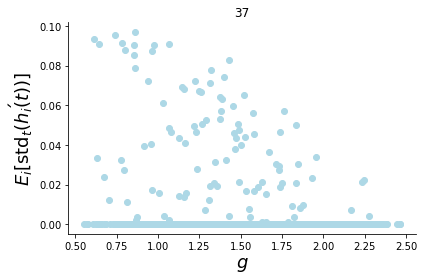

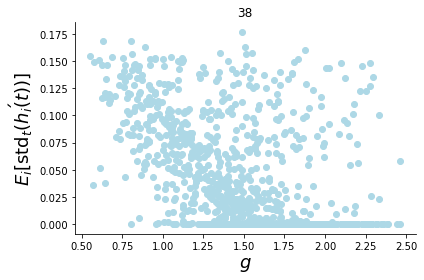

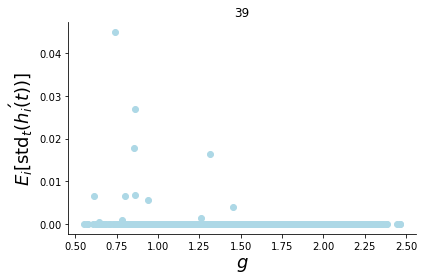

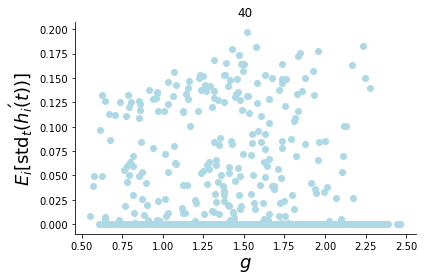

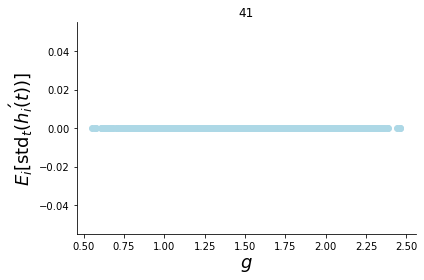

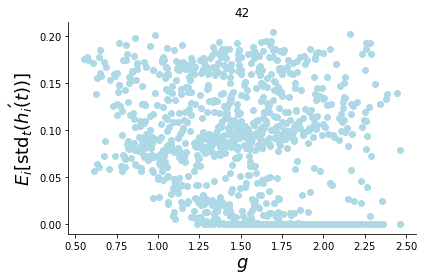

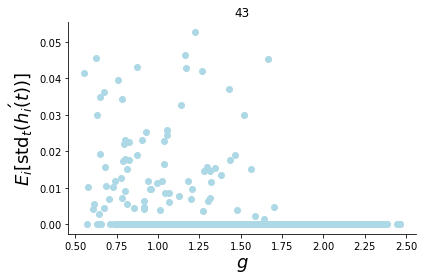

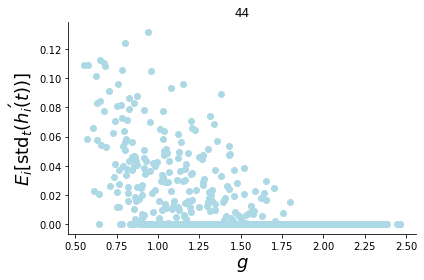

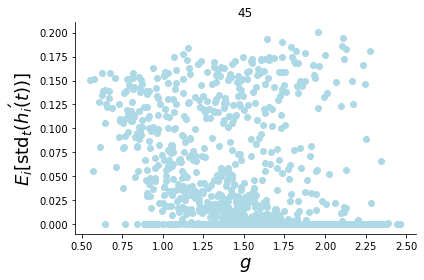

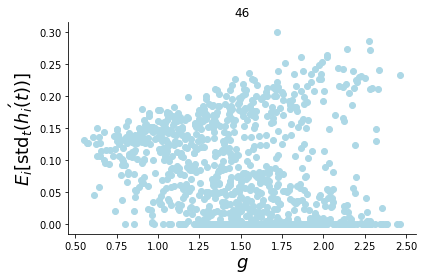

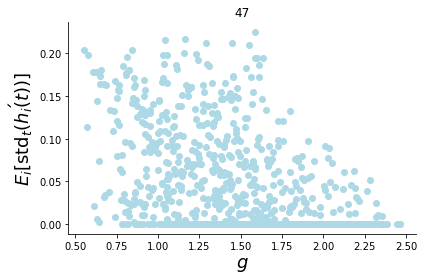

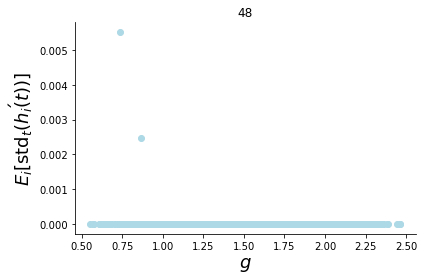

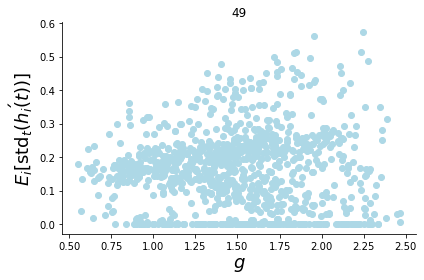

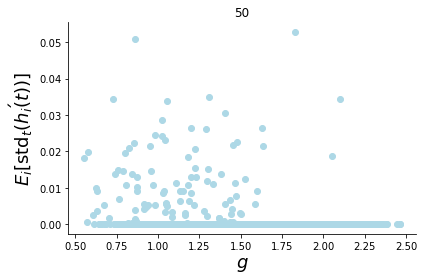

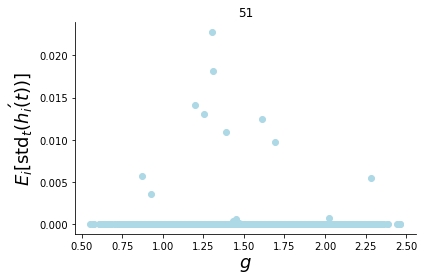

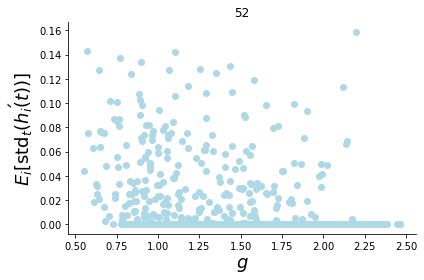

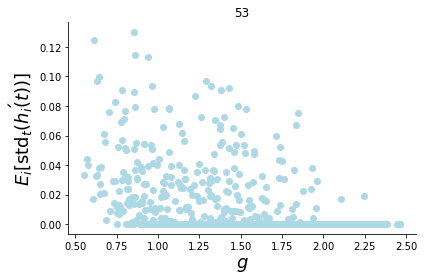

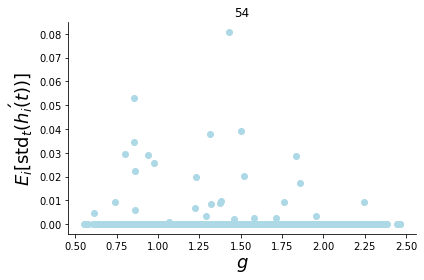

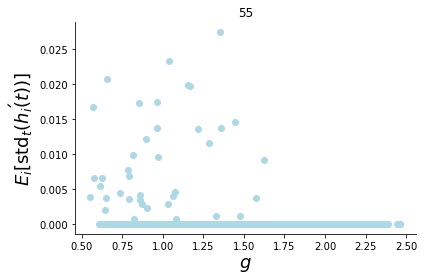

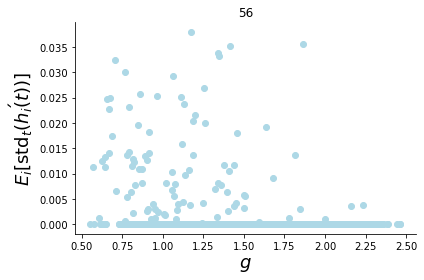

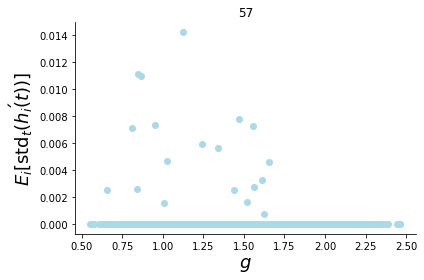

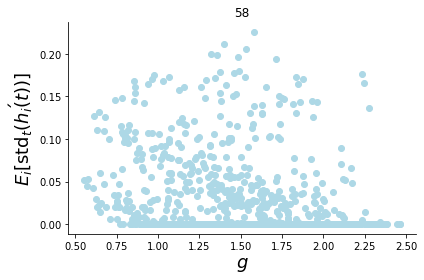

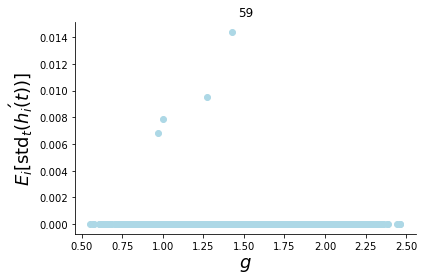

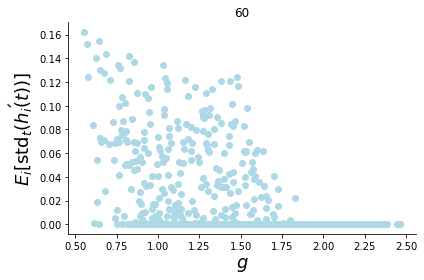

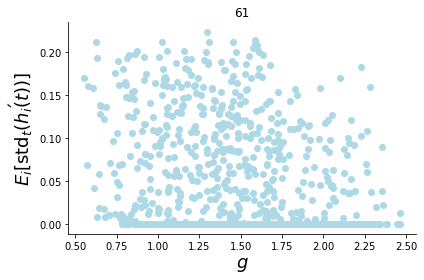

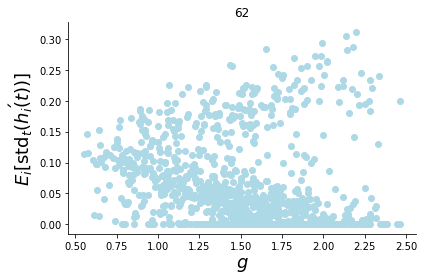

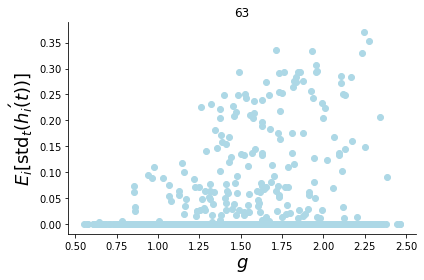

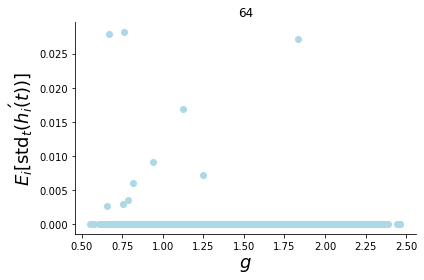

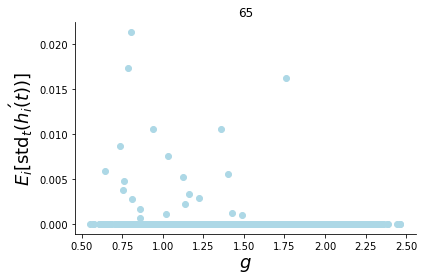

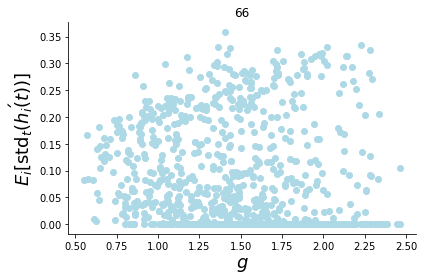

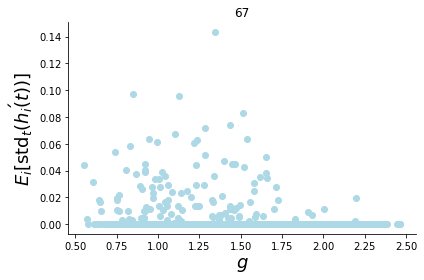

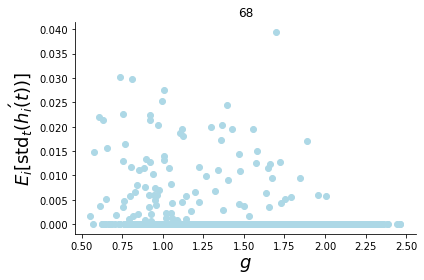

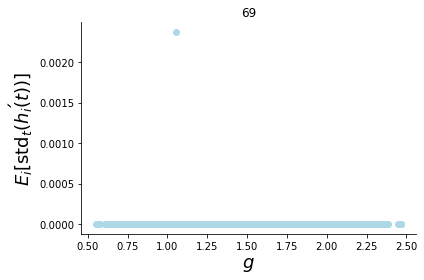

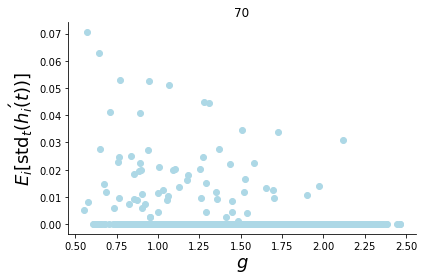

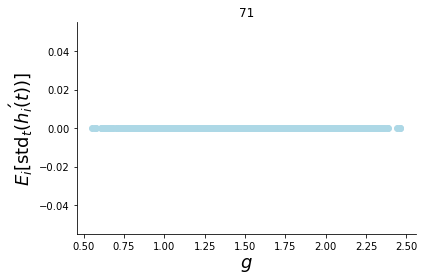

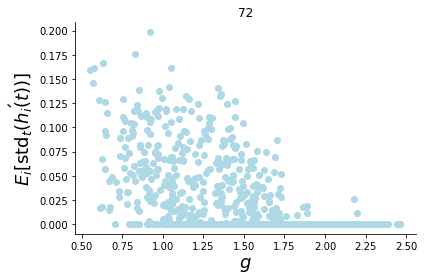

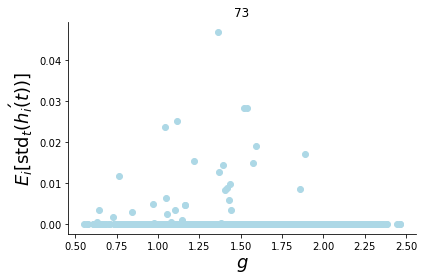

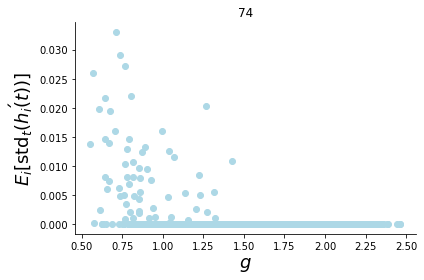

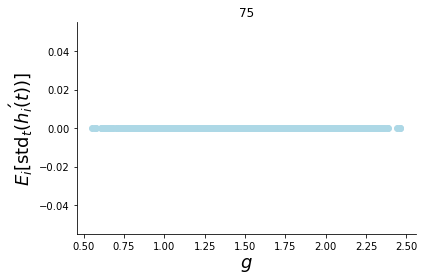

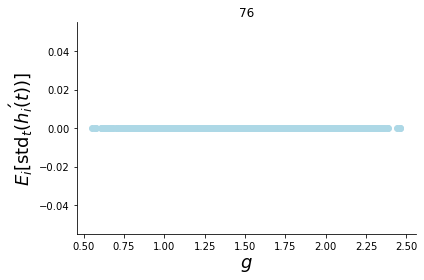

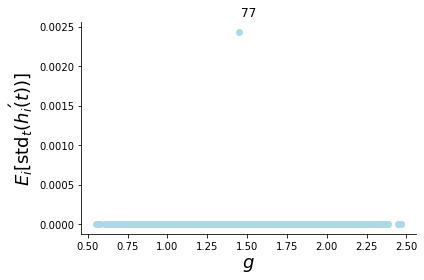

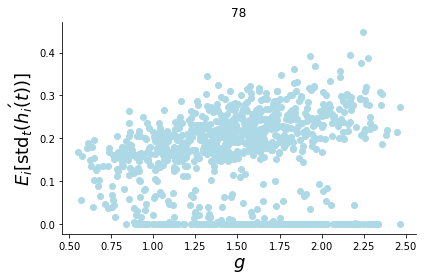

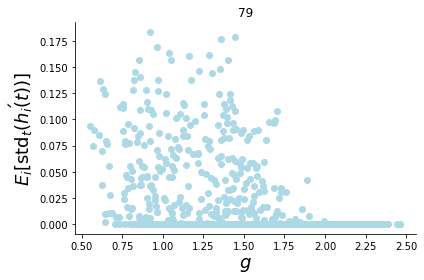

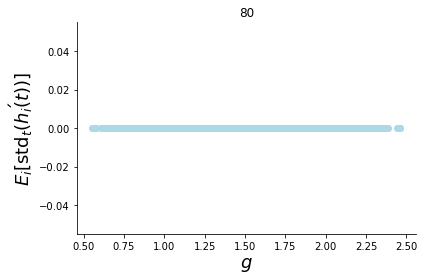

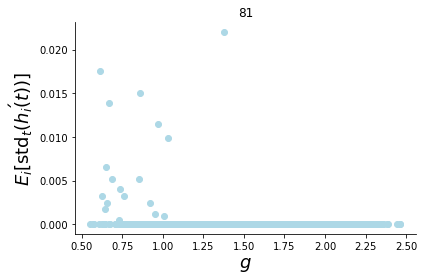

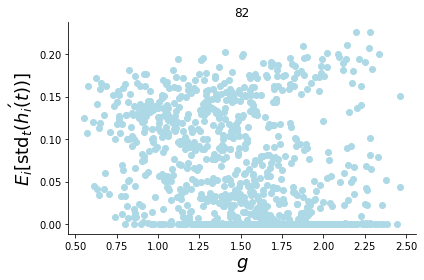

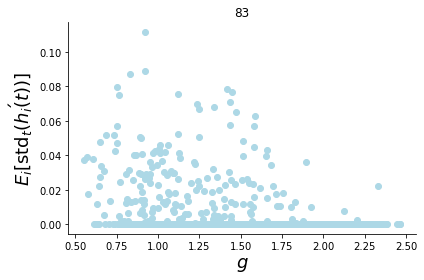

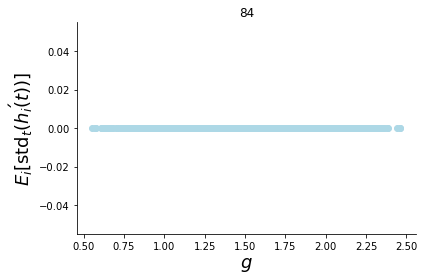

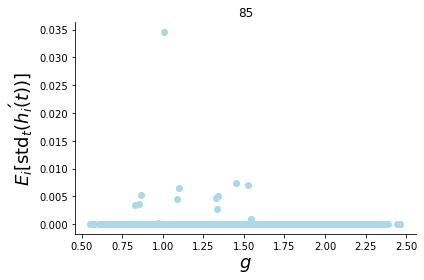

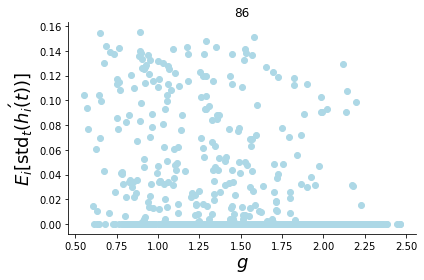

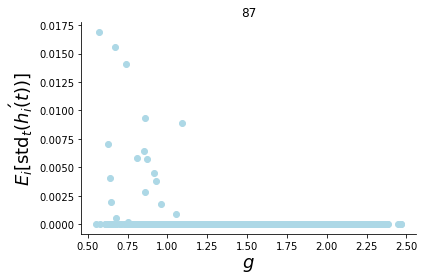

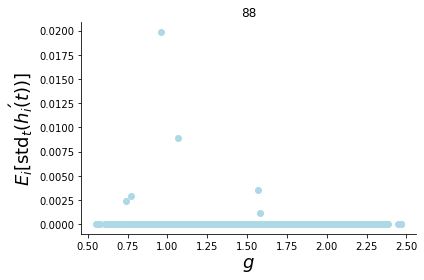

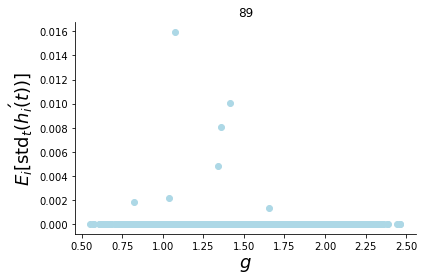

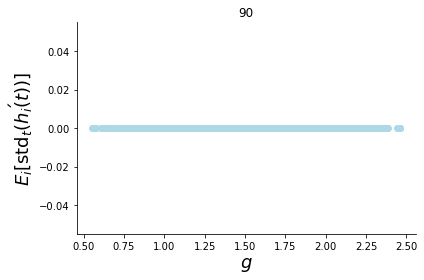

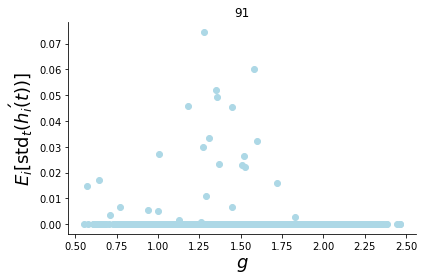

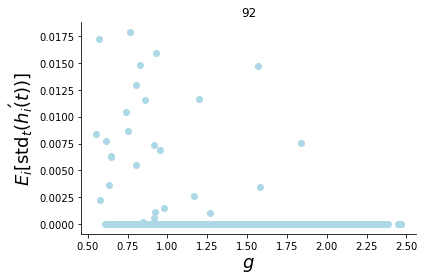

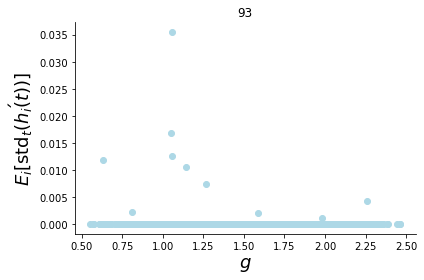

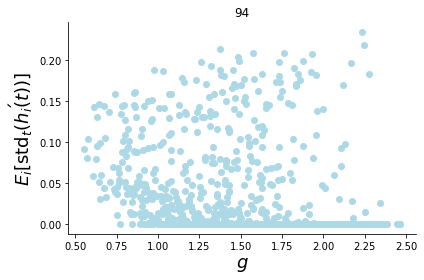

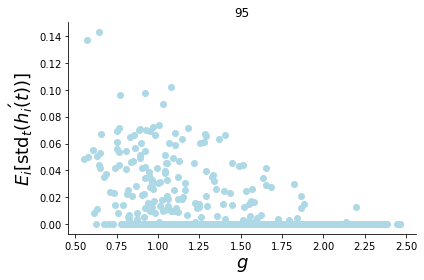

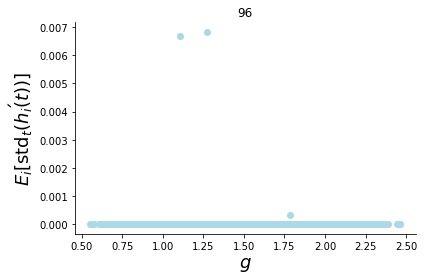

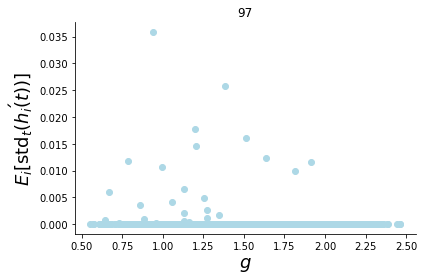

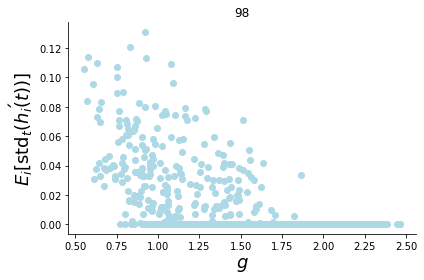

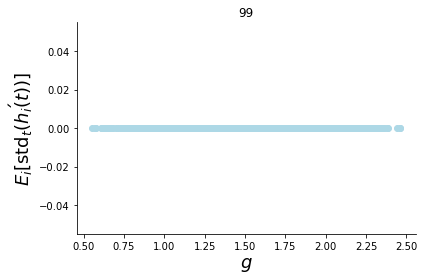

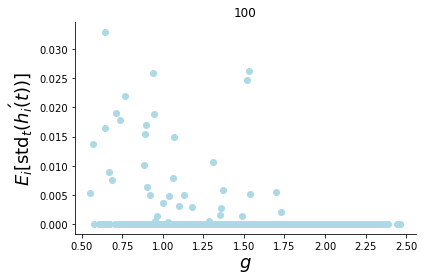

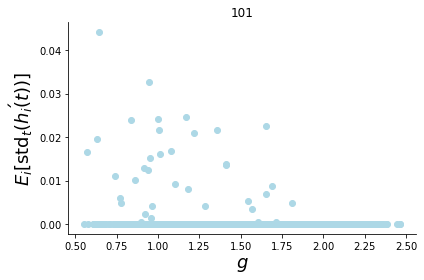

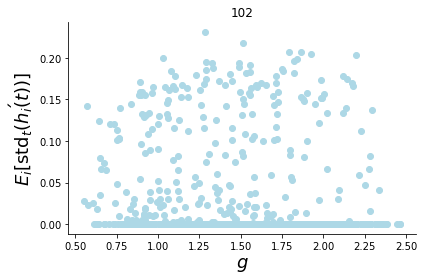

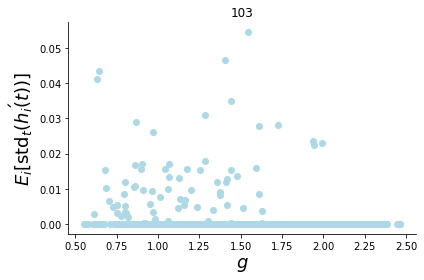

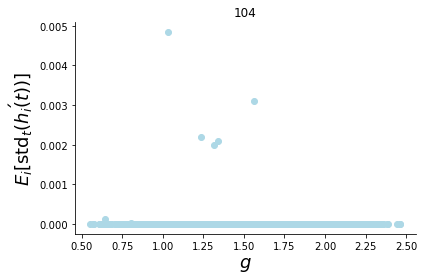

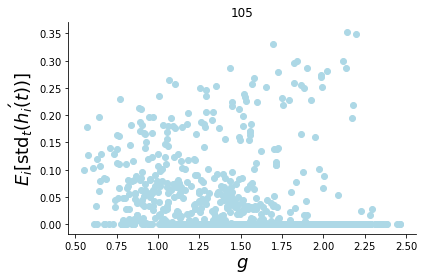

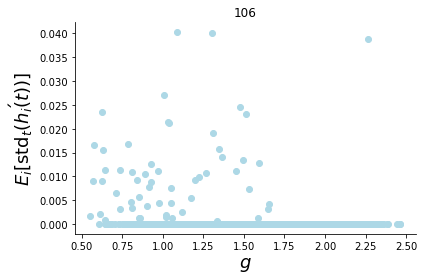

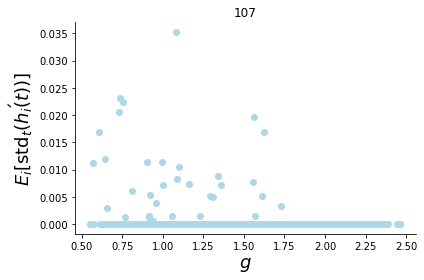

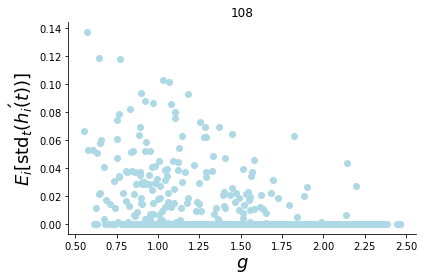

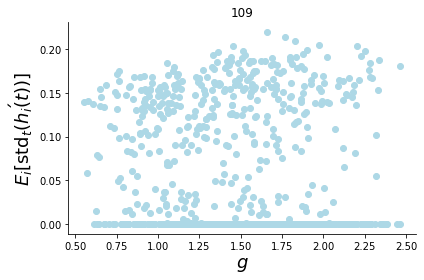

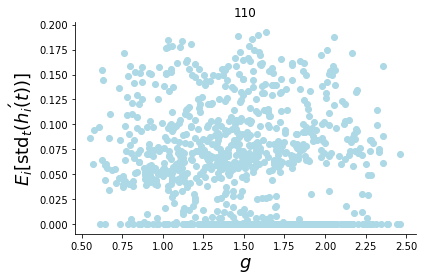

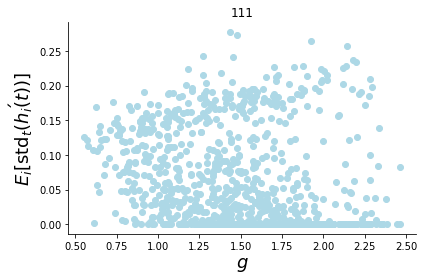

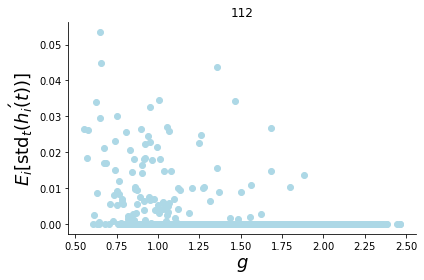

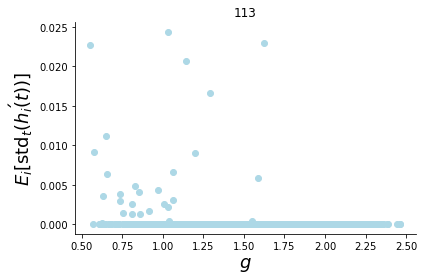

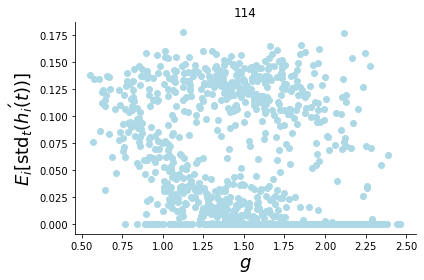

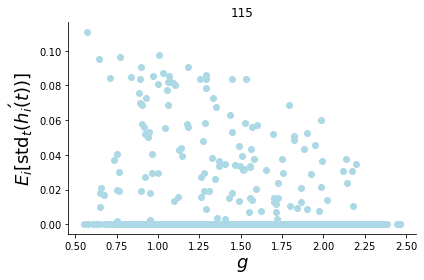

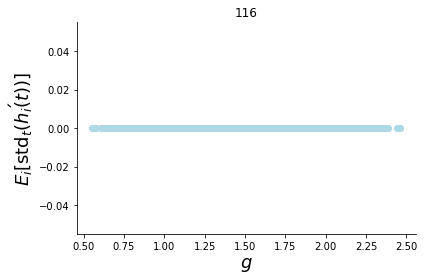

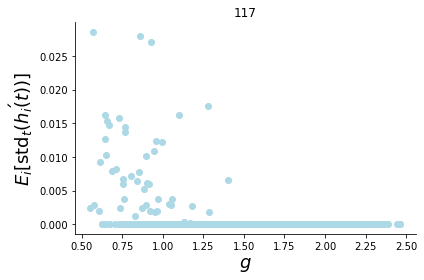

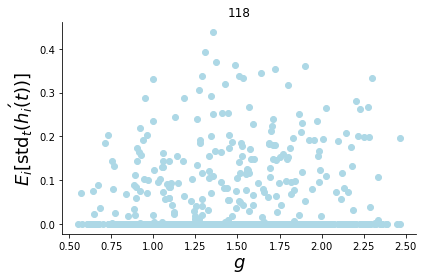

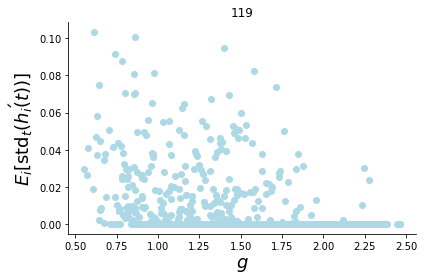

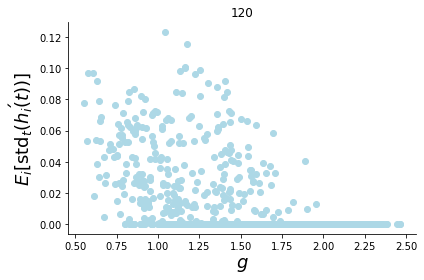

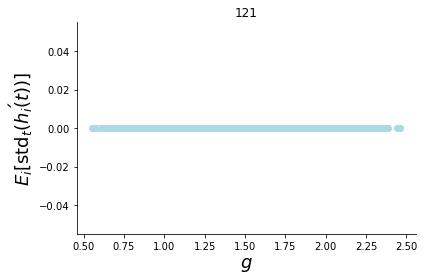

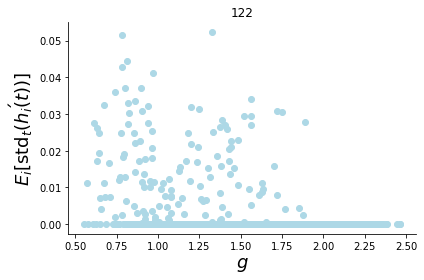

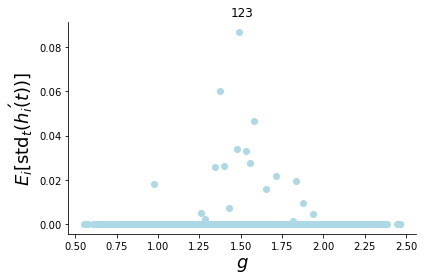

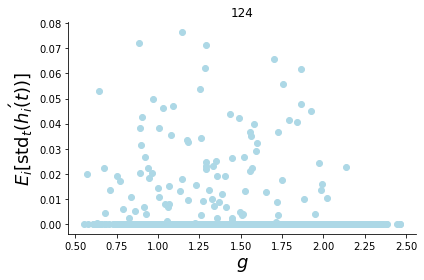

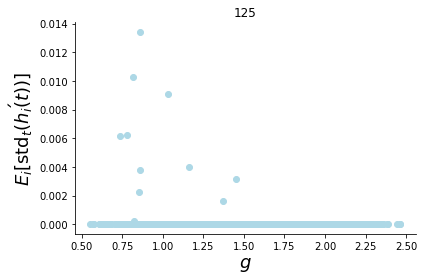

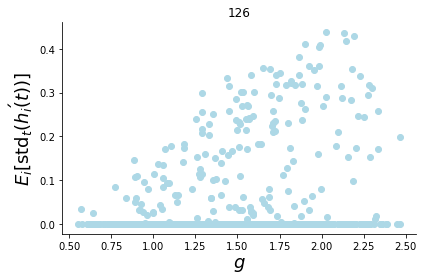

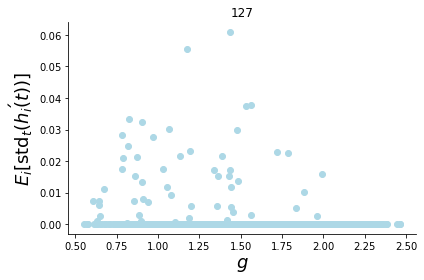

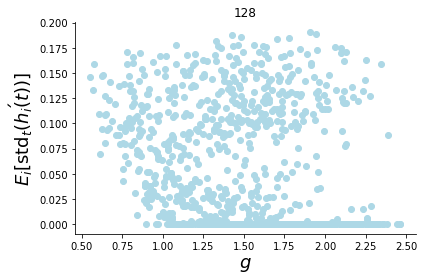

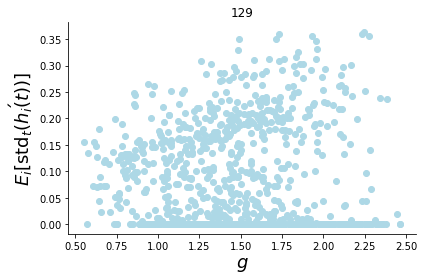

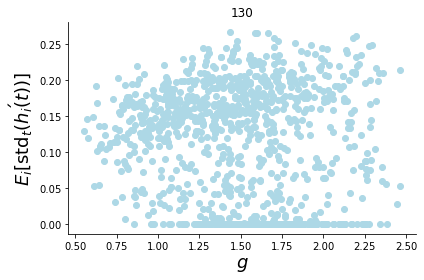

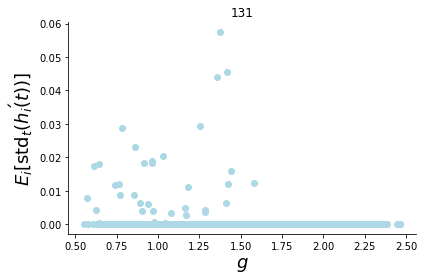

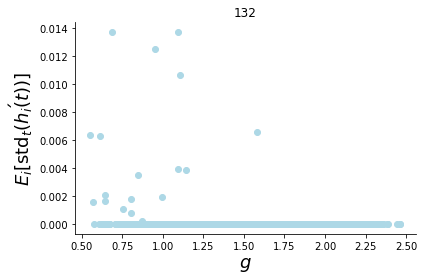

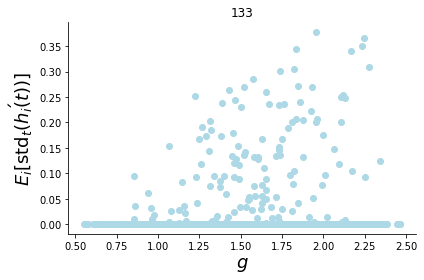

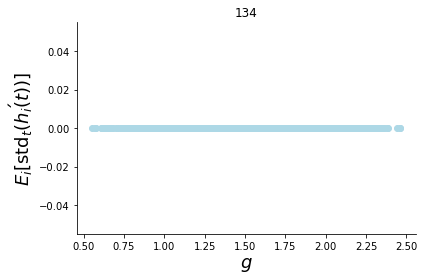

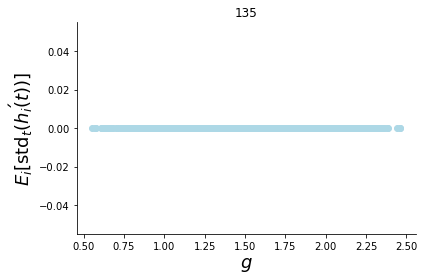

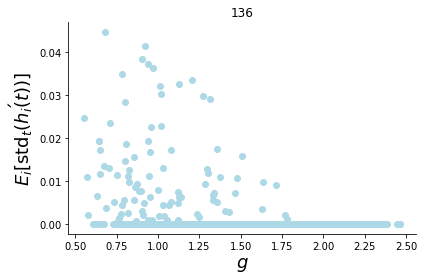

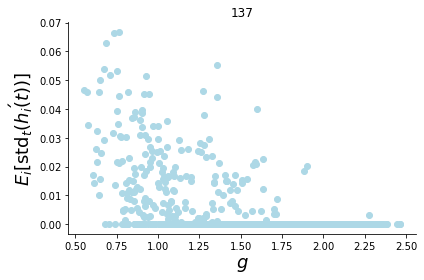

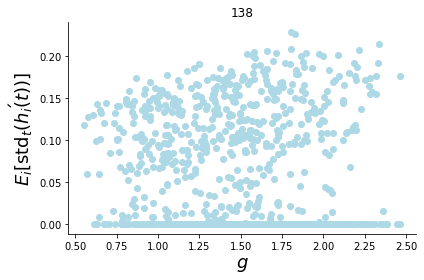

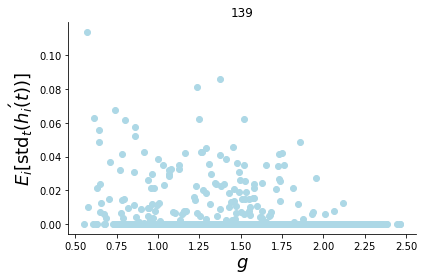

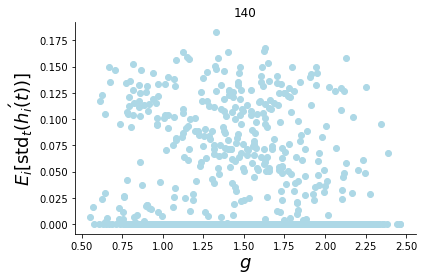

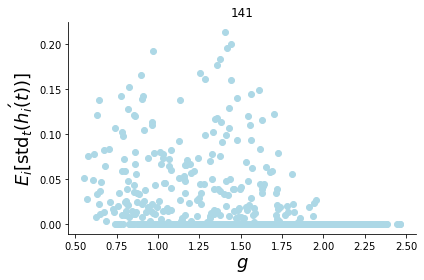

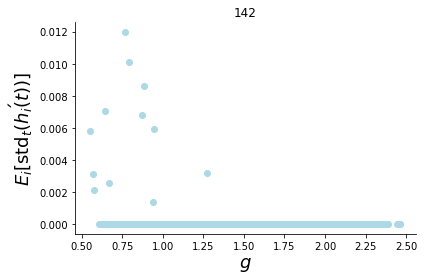

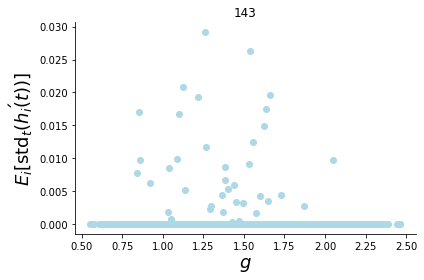

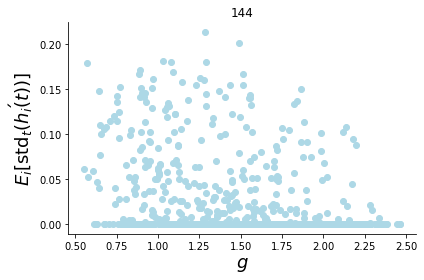

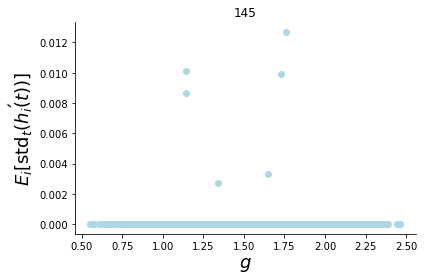

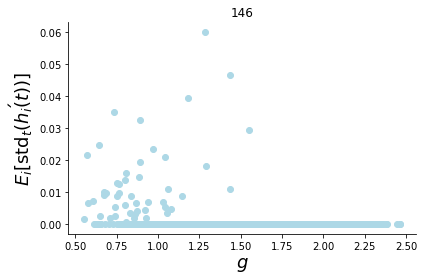

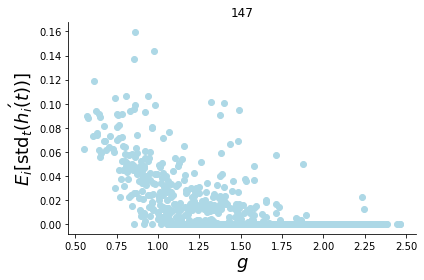

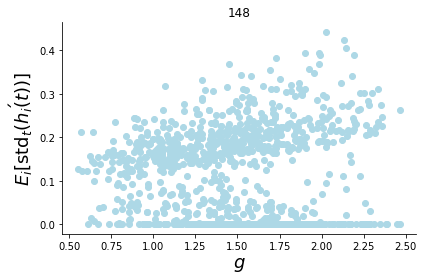

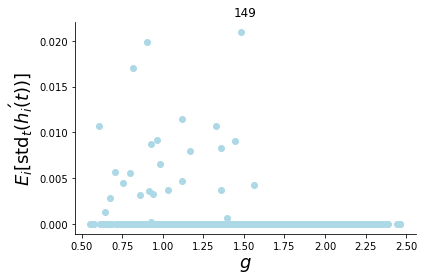

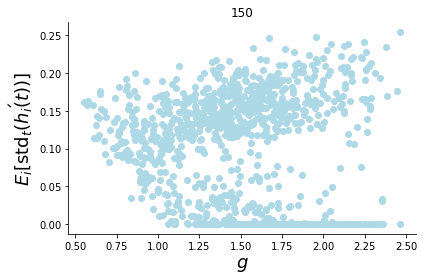

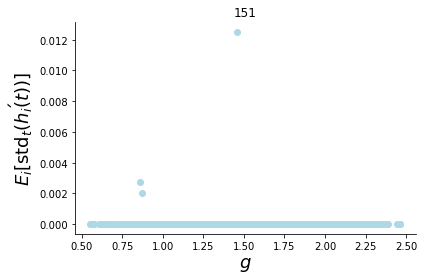

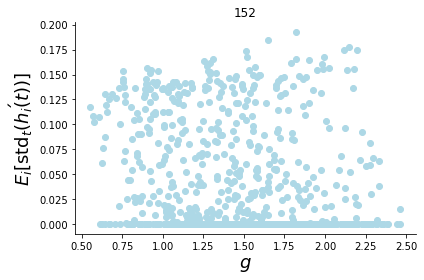

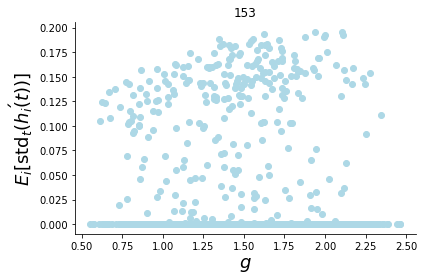

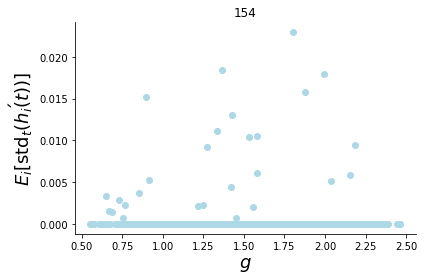

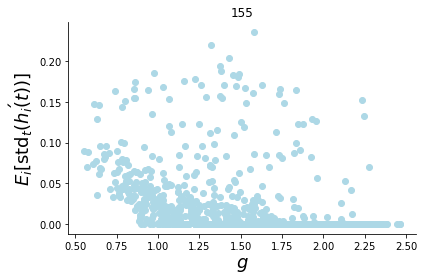

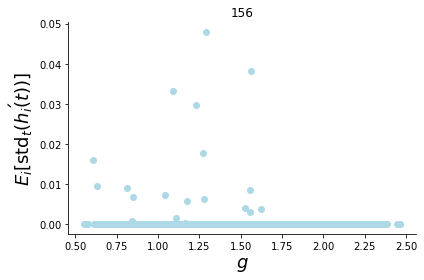

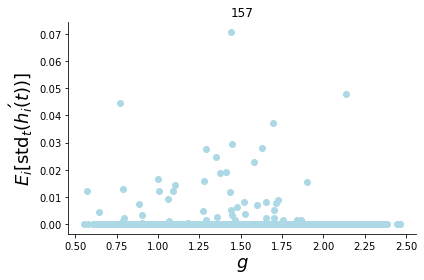

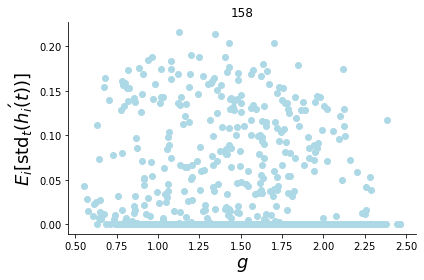

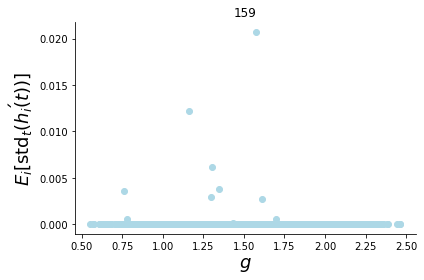

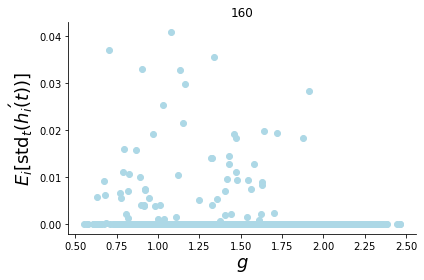

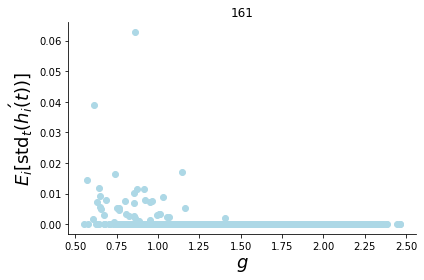

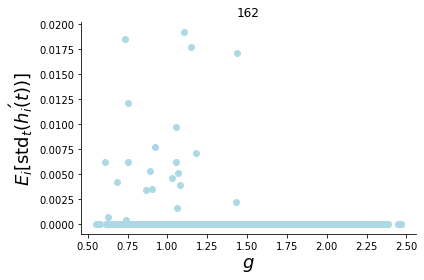

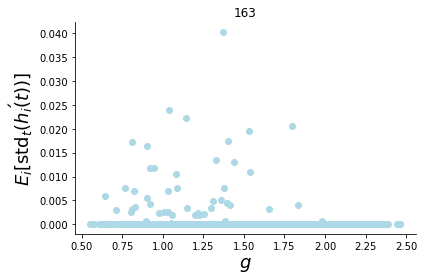

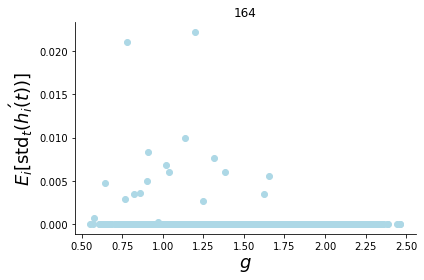

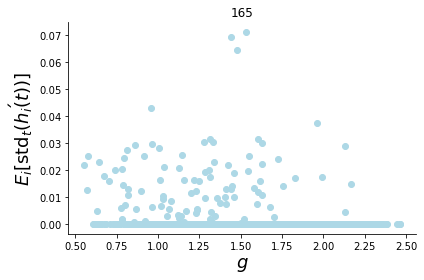

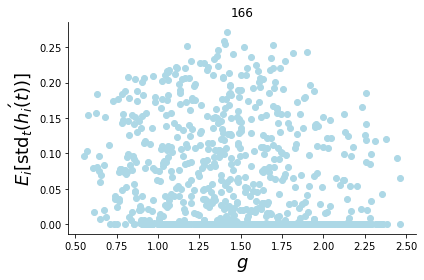

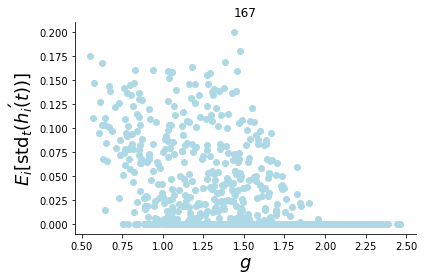

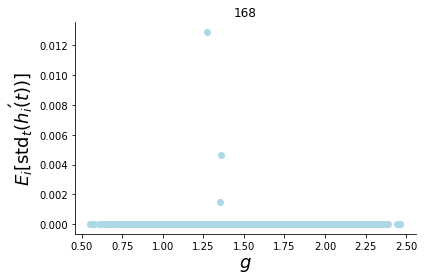

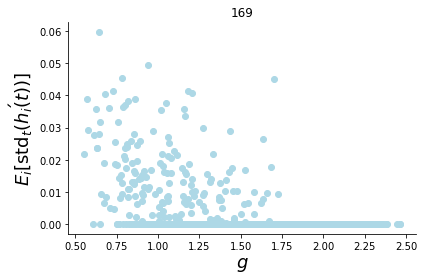

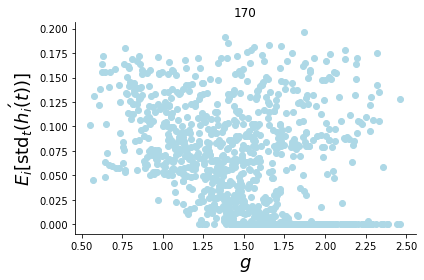

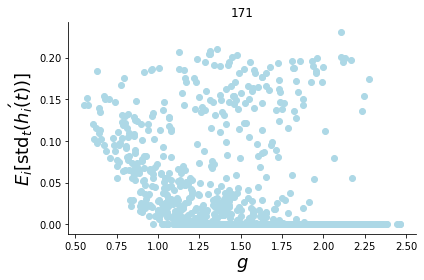

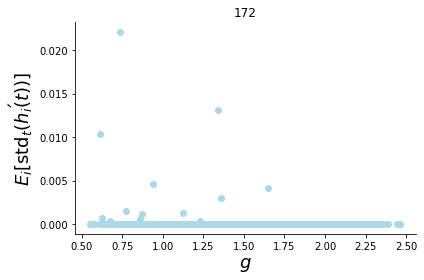

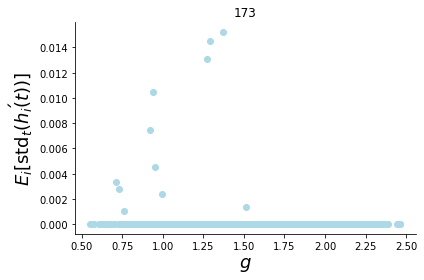

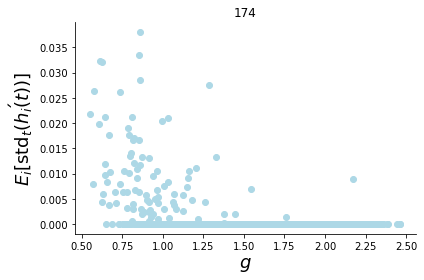

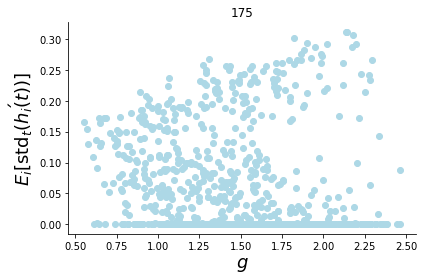

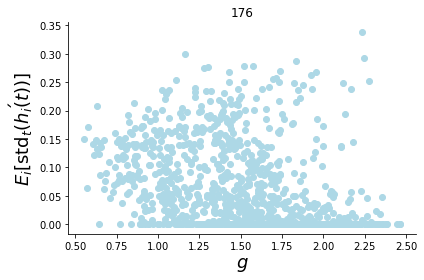

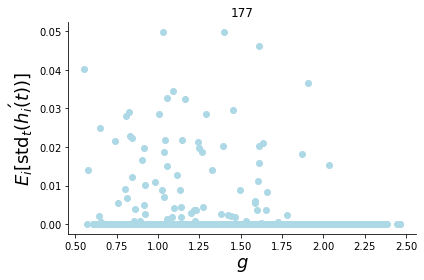

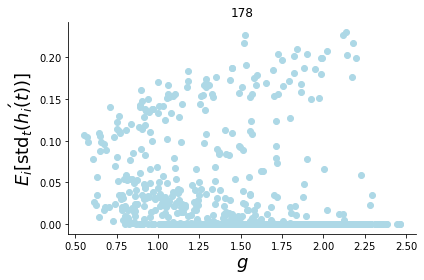

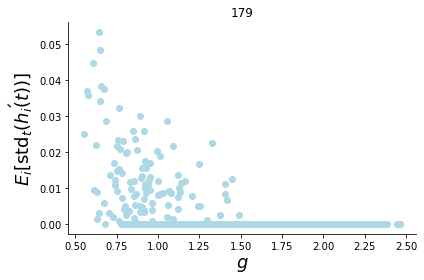

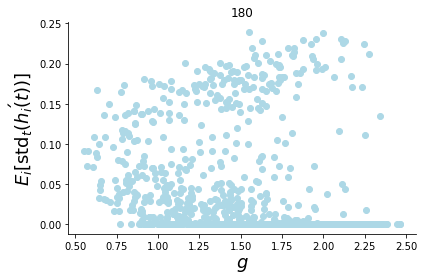

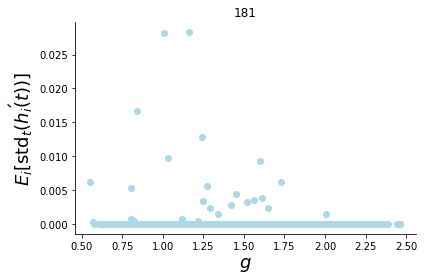

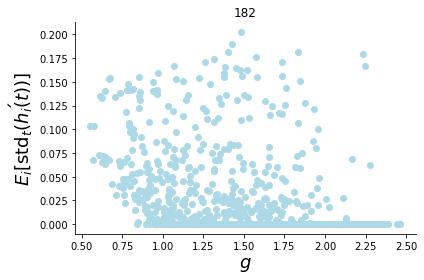

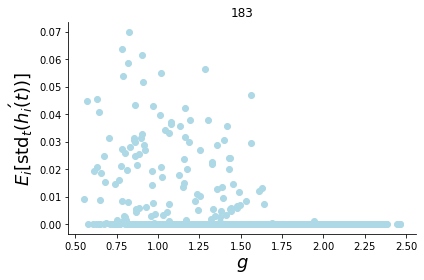

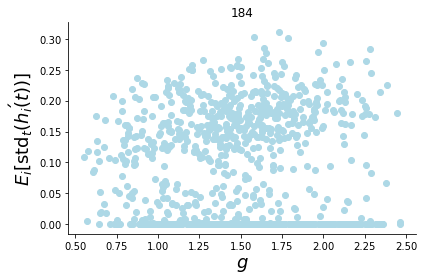

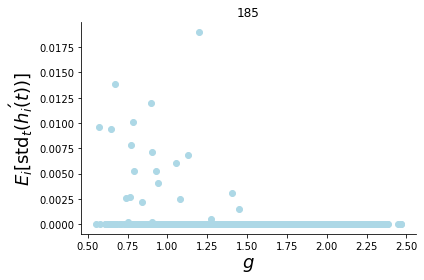

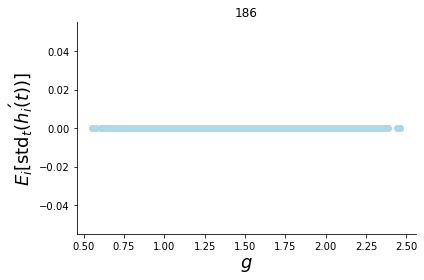

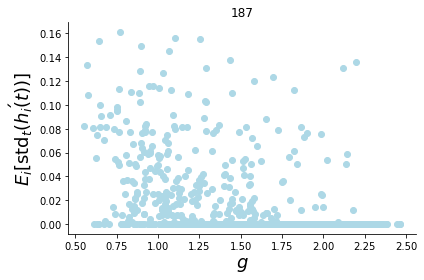

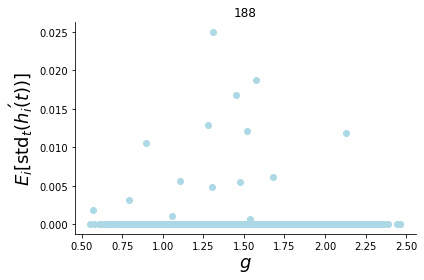

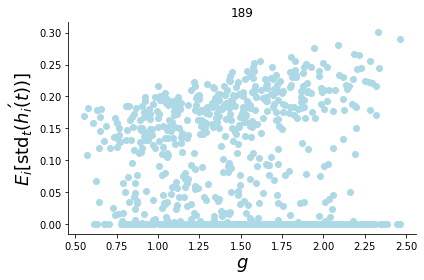

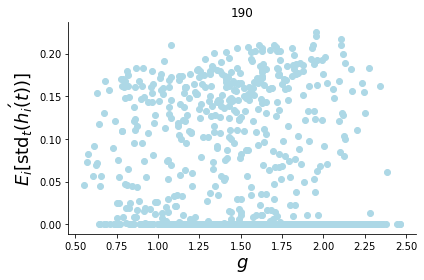

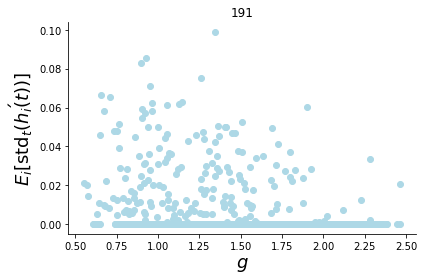

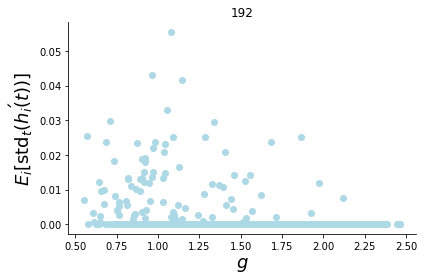

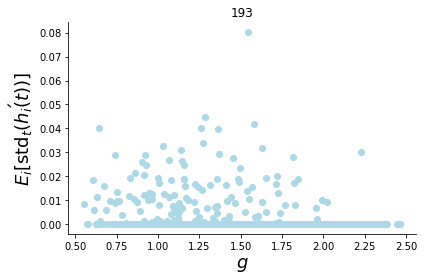

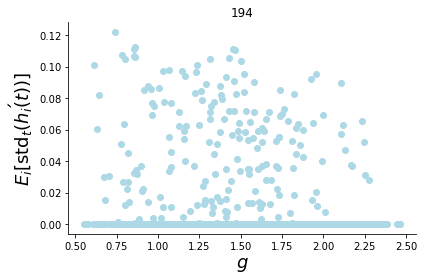

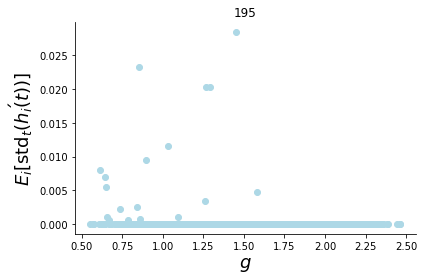

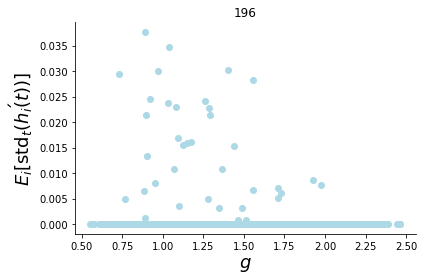

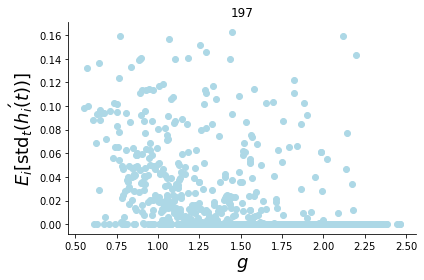

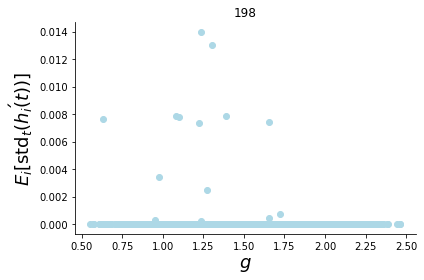

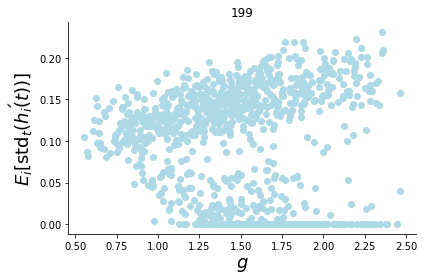

In [15]:
sample_num = 1000

outputs_np = np.zeros(sample_num)
input_signal, mu_post_list, sigma_post_list = make_signal_cc_task(sample_num, 
                                                                  time_length=cfg['DATALOADER']['TIME_LENGTH'], 
                                                                  mu_min=-15,
                                                                  mu_max=15,
                                                                  uncertainty=cfg['DATALOADER']['UNCERTAINTY'],
                                                                  fix_input=False)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

neural_dynamics = np.zeros((sample_num, cfg['DATALOADER']['TIME_LENGTH'], model.n_hid))                                                                        

hidden_np = np.zeros((sample_num, cfg['MODEL']['SIZE']))
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                                             
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs, _ = model(inputs, hidden, cfg['DATALOADER']['TIME_LENGTH'])                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()                          
# outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
# neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

for i in range(200):
    plt.scatter(
        1 / np.array(sigma_post_list) ** 2, 
        np.std(neural_dynamics[:, :, i], axis=1),
        color='lightblue',
    )

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

    plt.xlabel(r'$g$', fontsize=18)
    plt.ylabel(r'$E_i [{\rm std}_t (h_i\'(t))]$', fontsize=18)
    plt.title(i)
    plt.tight_layout()
    
# plt.savefig('figures/20_1_g_hidden_scatter.png', dpi=150)


    plt.show()

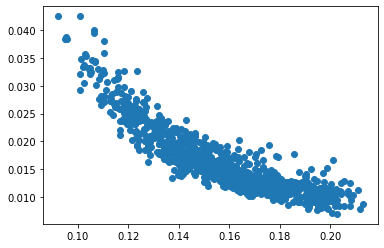

In [12]:
plt.scatter(
    np.mean(np.std(input_signal[:, :, :], axis=1), axis=1),
    np.mean(np.std(torch.nn.ReLU()(model.w_in(inputs)).detach().numpy(), axis=1), axis=1),
)

plt.show()

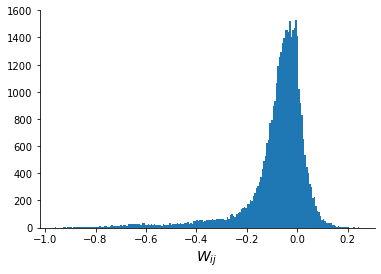

In [25]:
w_in_weight = model.w_in.weight.data.numpy().reshape(200**2)
plt.hist(w_in_weight, bins=200)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$W_{ij}$', fontsize=14)
plt.savefig('figures/19_1_w_in_distribution.eps', dpi=150)

In [26]:
print(np.mean(model.w_in.weight.data.numpy()))
print(np.std(model.w_in.weight.data.numpy()))

-0.07936282
0.12829244


In [100]:
print(np.mean(model.w_in.bias.data.numpy()))
print(np.std(model.w_in.bias.data.numpy()))

0.14894293
0.34769678


Text(0, 0.5, 'std of y(t)')

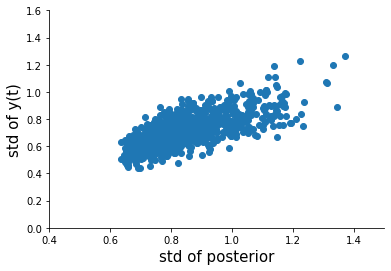

In [40]:
# plt.scatter(sigma_post_list, np.std(outputs.detach().numpy()[:, 20:, 0], axis=1))
plt.scatter(sigma_post_list, np.std(outputs.detach().numpy()[:, 20:, 0], axis=1))
plt.xlim([0.4, 1.5])
plt.ylim([0, 1.6])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel('std of posterior', fontsize=15)
plt.ylabel('std of y(t)', fontsize=15)

# plt.savefig('figures/19_1_std_scatter.eps', dpi=150)

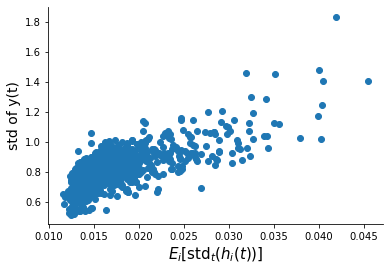

In [33]:
plt.scatter(
    np.mean(np.std(neural_dynamics[:, :, :], axis=1), axis=1),
    np.std(outputs.detach().numpy()[:, :, 0], axis=1),
)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$E_i [{\rm std}_t (h_i(t))]$', fontsize=15)
plt.ylabel('std of y(t)', fontsize=14)
plt.savefig('figures/19_1_neuron_output_scatter.eps', dpi=150)

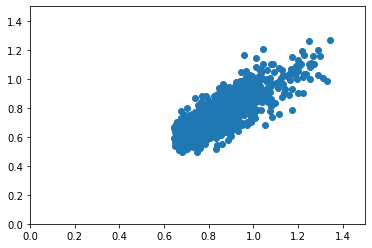

In [48]:
sample_num = 1000

outputs_np = np.zeros(sample_num)
input_signal, mu_post_list, sigma_post_list = make_signal_cc_task(sample_num, 
                                                                  time_length=cfg['DATALOADER']['TIME_LENGTH'], 
                                                                  mu_min=5,
                                                                  mu_max=5,
                                                                  uncertainty=cfg['DATALOADER']['UNCERTAINTY'],
                                                                  fix_input=False)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

neural_dynamics = np.zeros((sample_num, cfg['DATALOADER']['TIME_LENGTH'], model.n_hid))                                                                        

hidden_np = np.zeros((sample_num, cfg['MODEL']['SIZE']))
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                                             
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs, _ = model(inputs, hidden, cfg['DATALOADER']['TIME_LENGTH'])                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()                          
# outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
# neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

plt.scatter(sigma_post_list, np.std(outputs.detach().numpy()[:, :, 0], axis=1))
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])
plt.show()

In [51]:
sigma_post_list[0]

0.7231390333082908

In [49]:
pca = PCA(n_components=10)
# pca.fit(neural_dynamics[:, time_stamp, :])
pca.fit(neural_dynamics[0])

# neural_dynamics[0]

pca.explained_variance_ratio_

array([0.24016929, 0.16927212, 0.12269908, 0.09532811, 0.07794505,
       0.06924215, 0.05654034, 0.04748683, 0.02689718, 0.02477635],
      dtype=float32)

In [ ]:
from scipy import linalg


In [53]:
pca = PCA(n_components=10)
# pca.fit(neural_dynamics[:, time_stamp, :])
pca.fit(neural_dynamics[2])

# neural_dynamics[0]

pca.explained_variance_ratio_

array([0.2498774 , 0.15205473, 0.13227528, 0.08594736, 0.07771415,
       0.05852122, 0.04321132, 0.03812512, 0.0285092 , 0.02227408],
      dtype=float32)

In [ ]:
pca = PCA(n_components=10)
# pca.fit(neural_dynamics[:, time_stamp, :])
pca.fit(neural_dynamics[0])

# neural_dynamics[0]

pca.explained_variance_ratio_

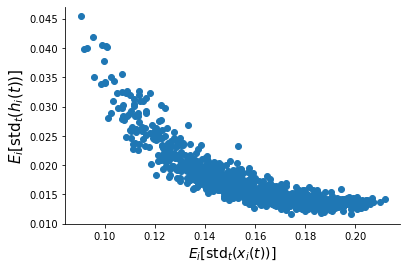

In [37]:
plt.scatter(
    np.mean(np.std(input_signal[:, :, :], axis=1), axis=1),
    np.mean(np.std(neural_dynamics[:, :, :], axis=1), axis=1),
)
# plt.xlim([0, 1.5])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$E_i [{\rm std}_t (x_i(t))]$', fontsize=14)
plt.ylabel(r'$E_i [{\rm std}_t (h_i(t))]$', fontsize=15)

plt.savefig('figures/19_1_input_hidden_scatter.eps', dpi=150)

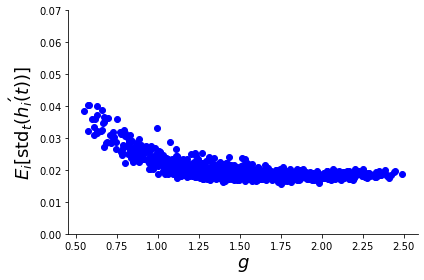

In [25]:
sample_num = 1000

outputs_np = np.zeros(sample_num)
input_signal, mu_post_list, sigma_post_list = make_signal_cc_task(sample_num, 
                                                                  time_length=cfg['DATALOADER']['TIME_LENGTH'], 
                                                                  mu_min=-10,
                                                                  mu_max=-10,
                                                                  uncertainty=cfg['DATALOADER']['UNCERTAINTY'],
                                                                  fix_input=False)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

neural_dynamics = np.zeros((sample_num, cfg['DATALOADER']['TIME_LENGTH'], model.n_hid))                                                                        

hidden_np = np.zeros((sample_num, cfg['MODEL']['SIZE']))
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                                             
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs, _ = model(inputs, hidden, cfg['DATALOADER']['TIME_LENGTH'])                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()    

plt.scatter(
    1 / np.array(sigma_post_list) ** 2, 
    np.mean(np.std(neural_dynamics[:, :, :], axis=1), axis=1),
    color='blue',
)
# plt.xlim([0, 1.5])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$g$', fontsize=18)
plt.ylabel(r'$E_i [{\rm std}_t (h_i\'(t))]$', fontsize=18)

plt.ylim([0, 0.07])
plt.tight_layout()
# plt.savefig('figures/19_1_g_hidden_scatter.png', dpi=150)


In [20]:
from scipy.stats import pearsonr

pearson_corr = pearsonr(
    1 / np.array(sigma_post_list) ** 2, 
    np.mean(np.std(neural_dynamics[:, :, :], axis=1), axis=1),
)

print(pearson_corr)

(-0.8475705258771872, 7.231667284607563e-277)


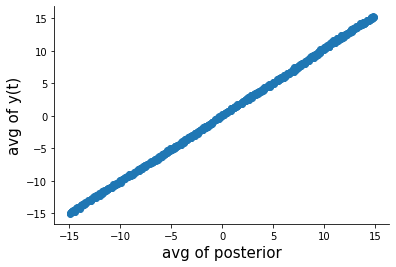

In [121]:
plt.scatter(
    mu_post_list, 
    np.mean(outputs.detach().numpy()[:, :, 0], axis=1),
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel('avg of posterior', fontsize=15)
plt.ylabel('avg of y(t)', fontsize=15)

plt.savefig('figures/19_1_avg_scatter.eps', dpi=150)

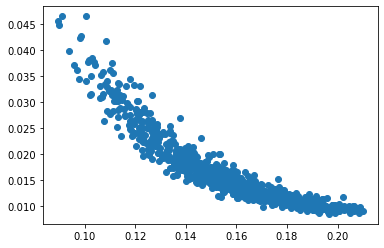

In [103]:
plt.scatter(
    np.mean(np.std(input_signal[:, :, :], axis=1), axis=1),
    np.mean(np.std(neural_dynamics[:, :, :], axis=1), axis=1),
)
# plt.xlim([0, 1.5])
# plt.ylim([0, 1.5])
plt.show()

In [81]:
from scipy.stats import pearsonr

pearson_corr = pearsonr(
    mu_post_list, 
    np.mean(outputs.detach().numpy()[:, 0:, 0], axis=1)
)

print(pearson_corr)

(0.9959530566888836, 0.0)


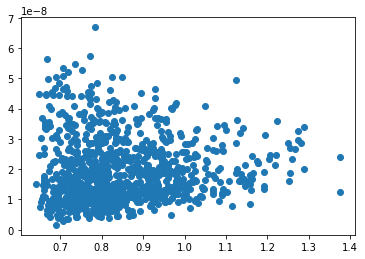

In [80]:
plt.scatter(
    sigma_post_list,
    np.mean(np.std(neural_dynamics[:, :, :], axis=1), axis=1),
)
# plt.xlim([0, 1.5])
# plt.ylim([0, 1.5])
plt.show()

In [55]:
from scipy.stats import pearsonr

pearson_corr = pearsonr(
    sigma_post_list, 
    np.std(outputs.detach().numpy()[:, 0:, 0], axis=1)
)

print(pearson_corr)

(0.742764353992023, 4.617449806654842e-176)


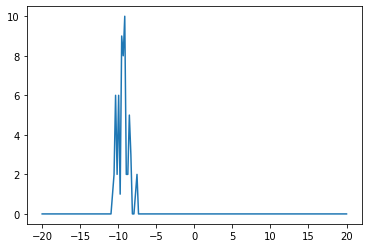

In [44]:
plt.plot(np.linspace(-20, 20, 200),
         np.histogram(outputs.detach().numpy()[4, :, 0], bins=200, range=(-20, 20))[0])

In [56]:
print(mu_post_list[1], sigma_post_list[1])
print(mu_post_list[2], sigma_post_list[2])
print(mu_post_list[4], sigma_post_list[4])
print(mu_post_list[9], sigma_post_list[9])


13.939077520990804 0.8387513006861919
-13.593549898503287 0.7156535136525525
-8.312467442785463 0.7634175768866489
1.9720063367617227 0.9828439712549509


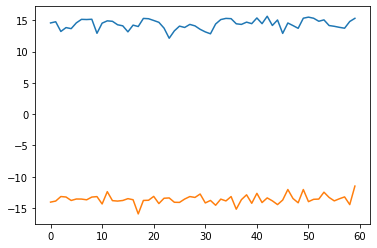

In [57]:
plt.plot(outputs.detach().numpy()[1, :, 0])
plt.plot(outputs.detach().numpy()[2, :, 0])
# plt.plot(outputs.detach().numpy()[4, :, 0])
# plt.plot(outputs.detach().numpy()[9, :, 0])

In [58]:
print(np.std((outputs.detach().numpy()[1, :, 0])))
print(np.std((outputs.detach().numpy()[2, :, 0])))

0.7728036
0.7067115


In [59]:
np.mean(np.sum((neural_dynamics>0)[:, :, :], axis=2), axis=1).shape

(1000,)

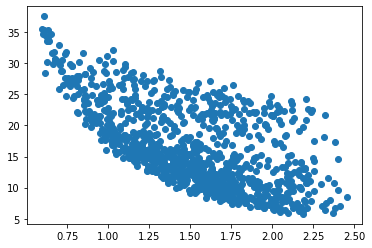

In [60]:
plt.scatter(
    1 / np.array(sigma_post_list) ** 2, 
    np.mean(np.sum((neural_dynamics>0)[:, 20:, :], axis=2), axis=1),
)
plt.show()

In [61]:
from scipy.stats import pearsonr

pearsonr(
    1 / np.array(sigma_post_list) ** 2, 
    np.mean(np.sum((neural_dynamics>0)[:, 20:, :], axis=2), axis=1),
)

(-0.6202410296881282, 2.310784215664271e-107)

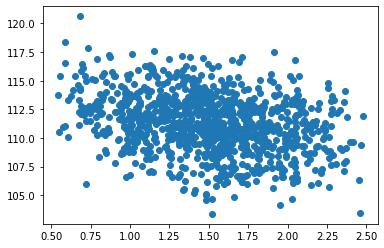

In [123]:
plt.scatter(
    1 / np.array(sigma_post_list) ** 2, 
    np.mean(np.sum((neural_dynamics>0)[:, 20:, :], axis=2), axis=1),
)
plt.show()

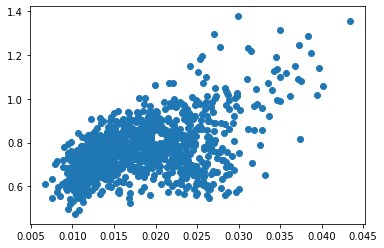

In [17]:
plt.scatter(
    np.mean(np.std(neural_dynamics[:, :, :], axis=1), axis=1),
    np.std(outputs.detach().numpy()[:, :, 0], axis=1),
)
plt.show()

In [121]:
print(sigma_post_list[4])
print(sigma_post_list[5])

0.6965112012920162
1.0103932088751473


In [130]:
print(np.std(outputs.detach().numpy()[4, :, 0]))
print(np.std(outputs.detach().numpy()[5, :, 0]))


0.57021344
0.85606915


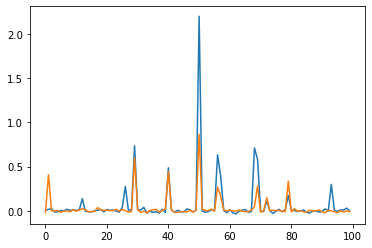

In [138]:
plt.plot(np.mean(neural_dynamics[4, :, 100:200], axis=0))
plt.plot(np.mean(neural_dynamics[5, :, 100:200], axis=0))

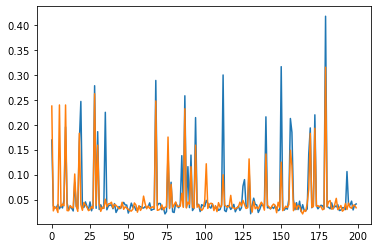

In [132]:
plt.plot(np.std(neural_dynamics[4, :, :], axis=0))
plt.plot(np.std(neural_dynamics[5, :, :], axis=0))

In [135]:
print(np.mean(np.std(neural_dynamics[4, :, :], axis=0)))
print(np.mean(np.std(neural_dynamics[5, :, :], axis=0)))

0.057364844
0.051794562


In [133]:
np.mean(model.w_hh.weight.data.numpy())

-0.02684968

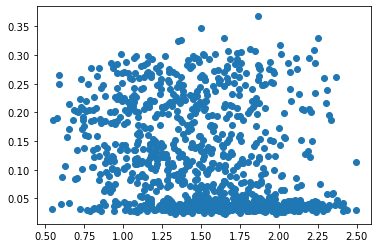

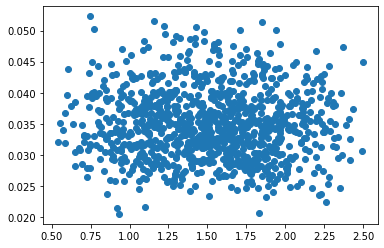

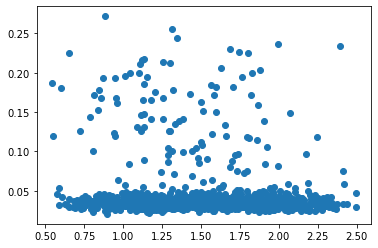

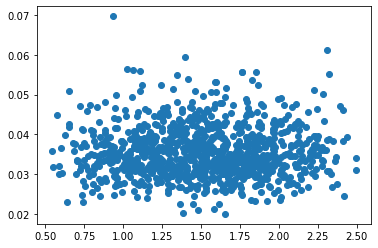

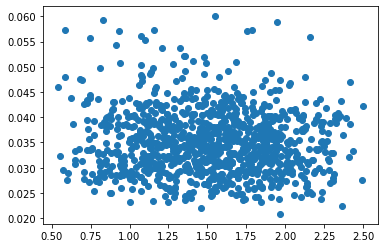

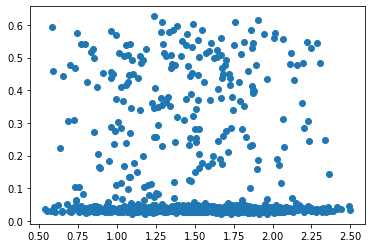

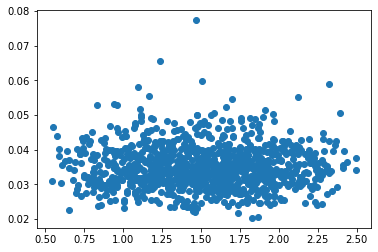

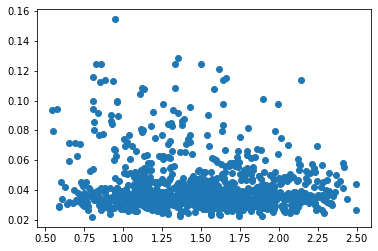

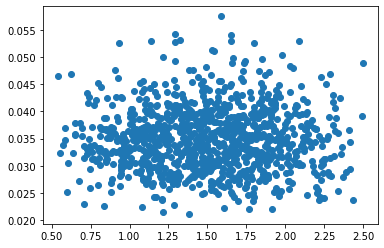

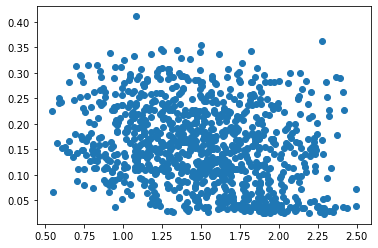

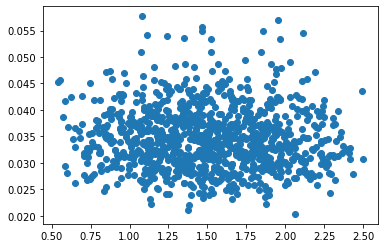

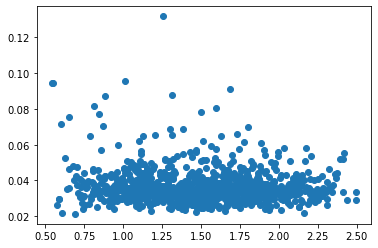

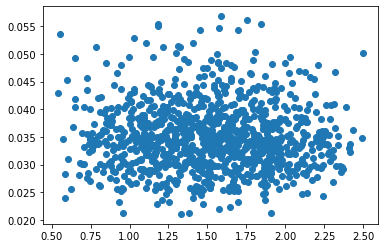

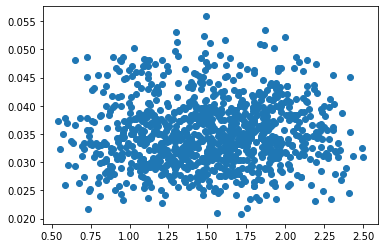

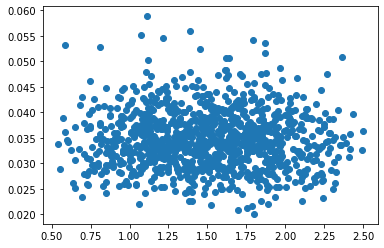

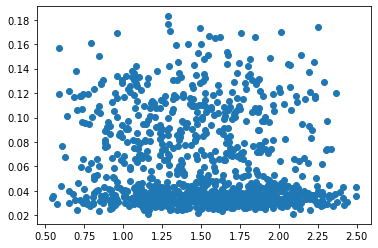

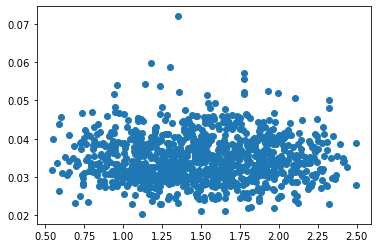

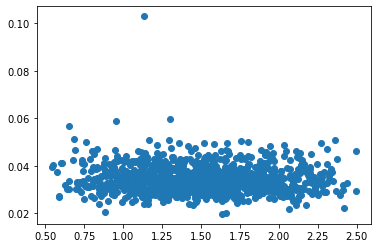

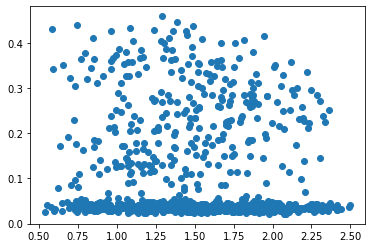

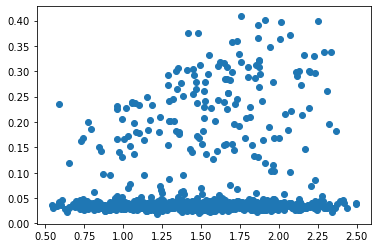

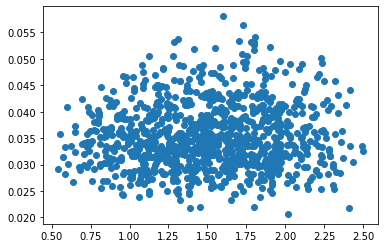

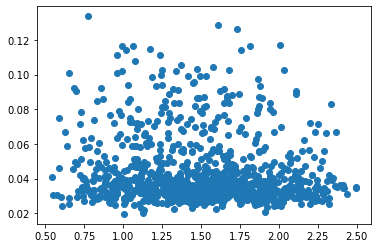

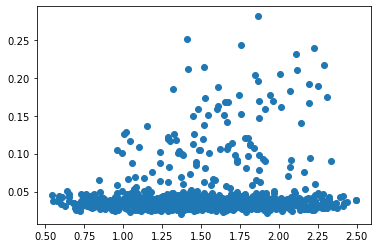

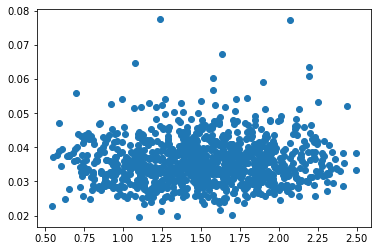

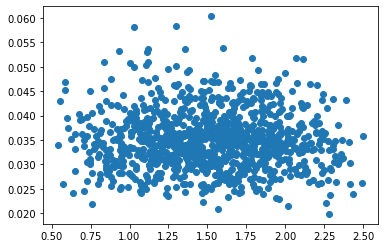

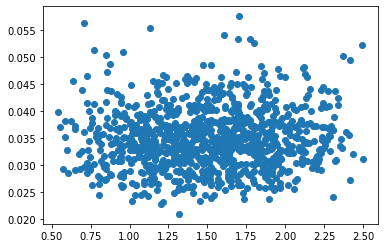

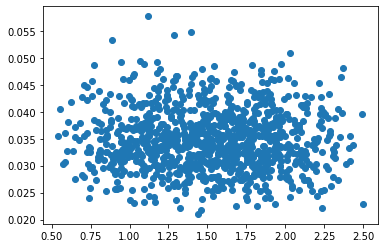

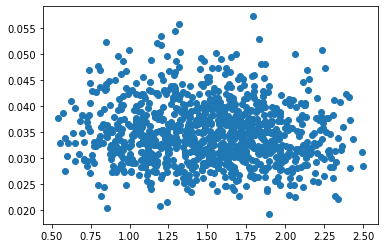

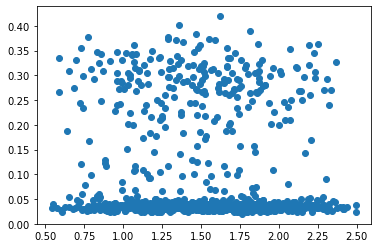

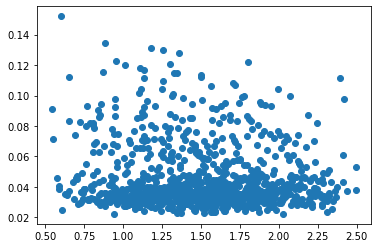

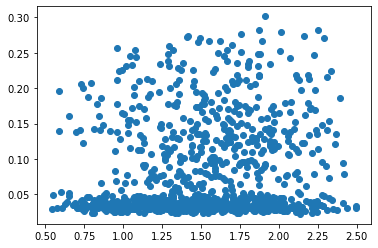

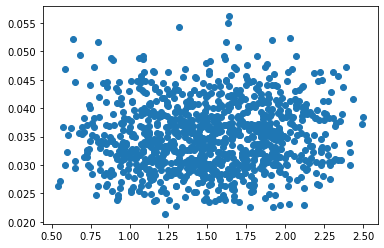

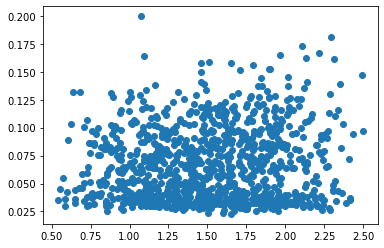

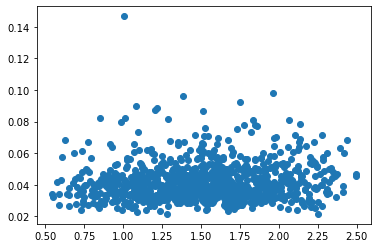

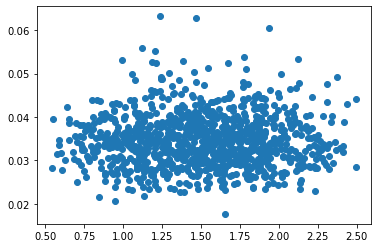

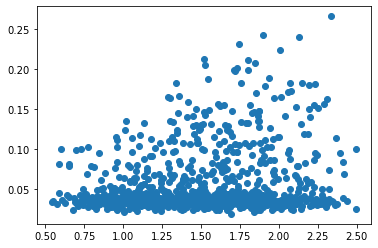

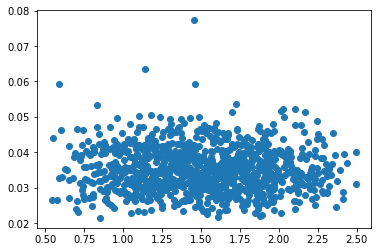

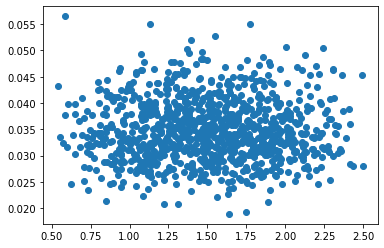

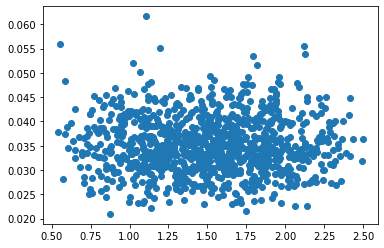

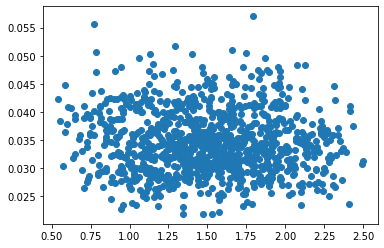

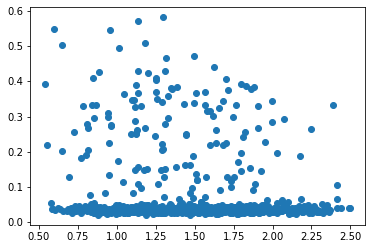

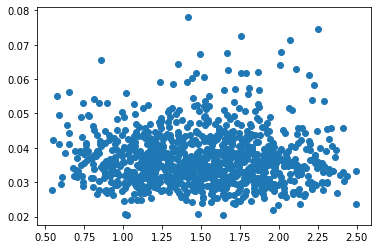

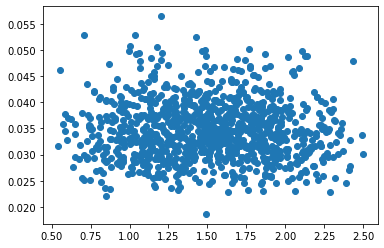

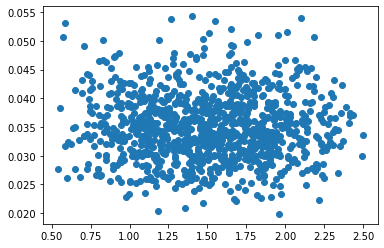

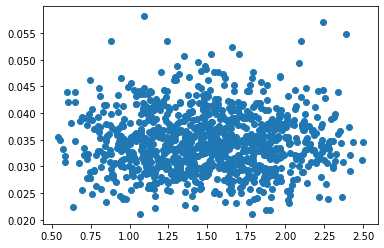

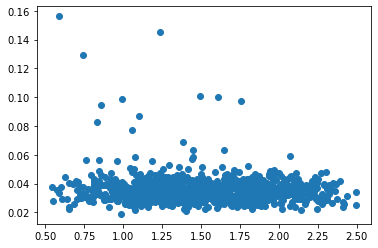

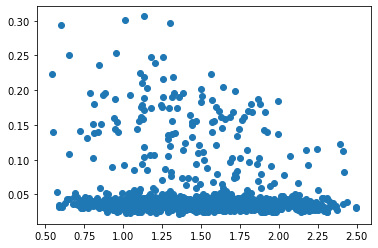

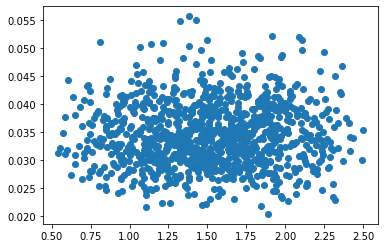

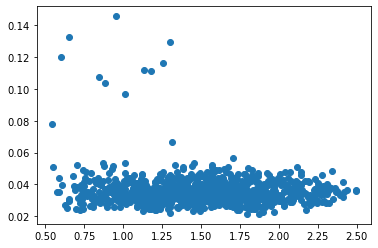

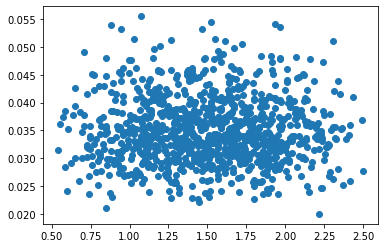

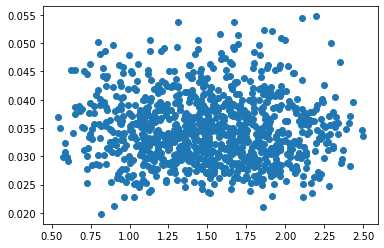

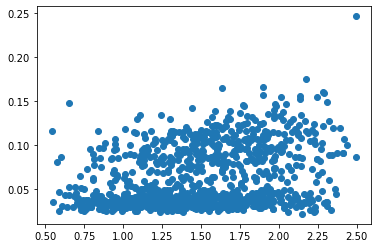

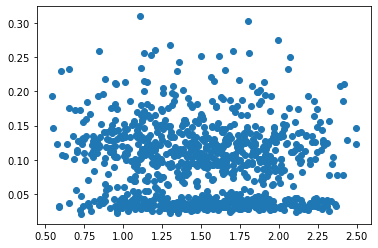

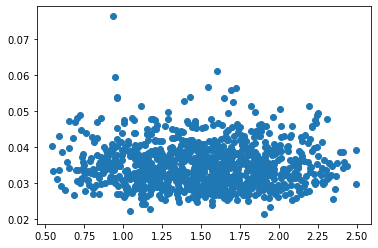

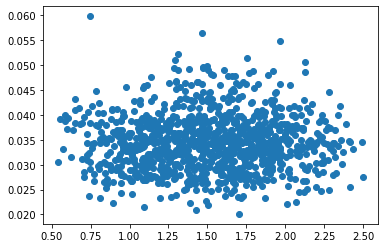

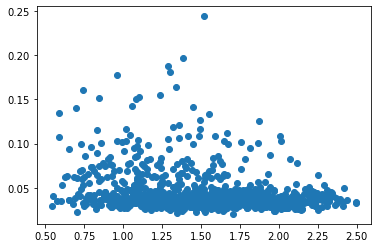

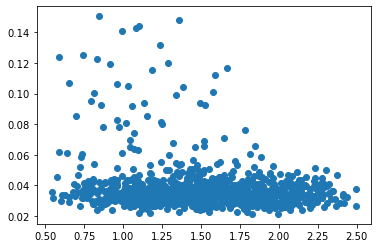

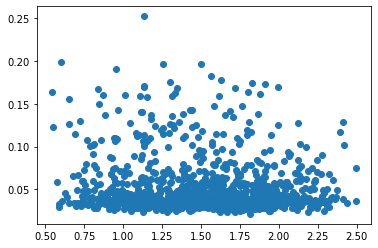

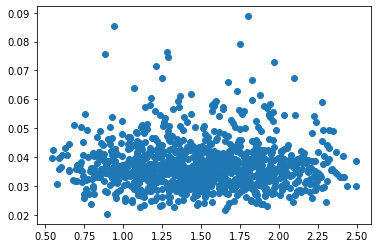

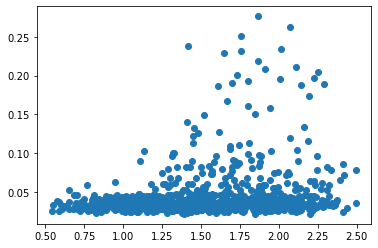

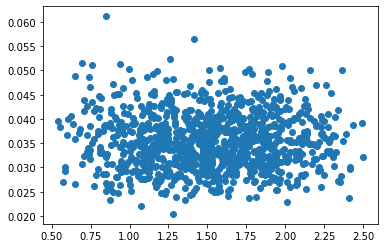

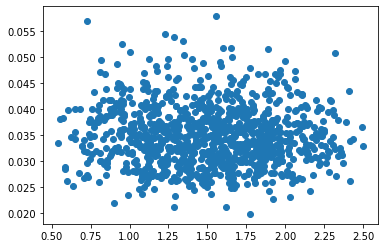

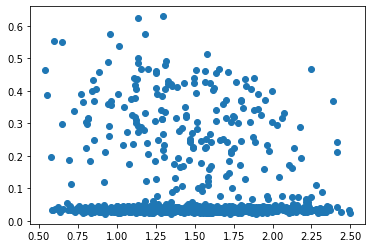

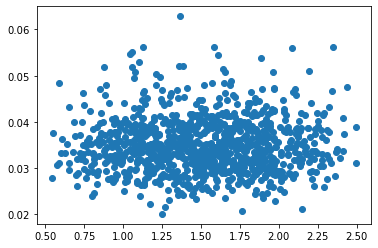

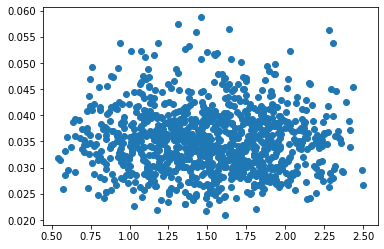

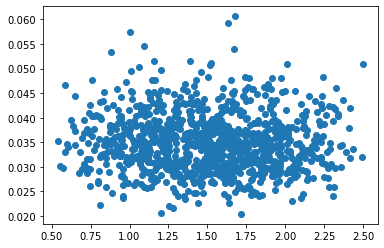

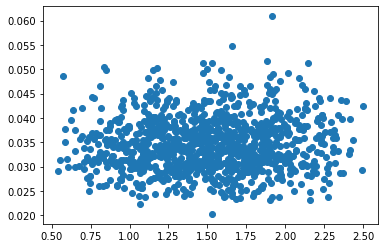

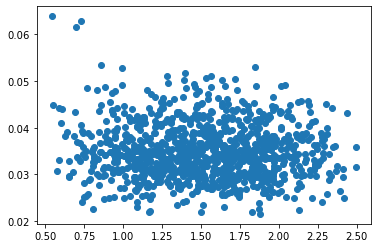

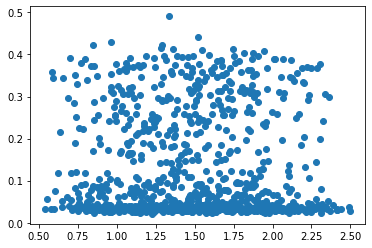

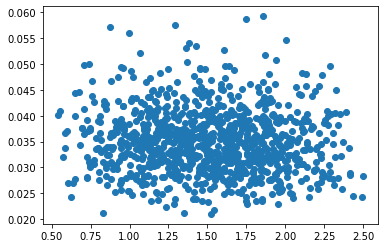

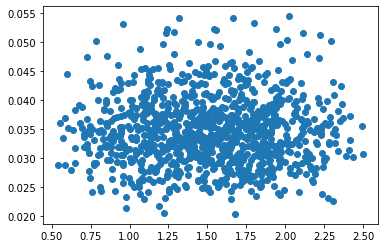

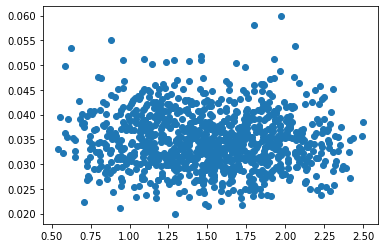

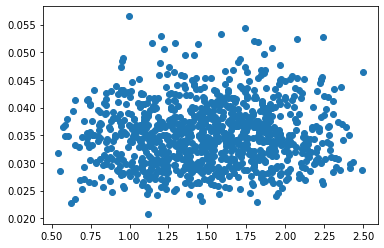

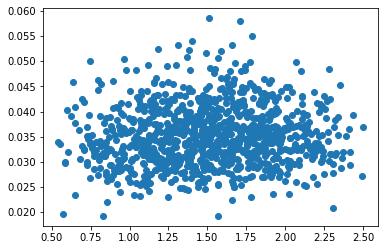

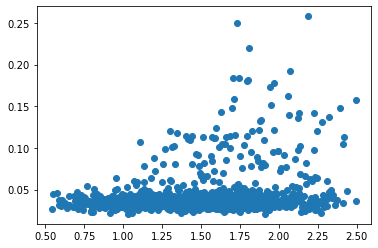

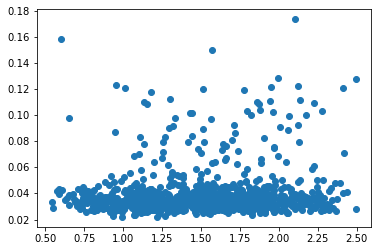

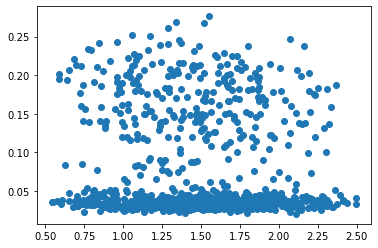

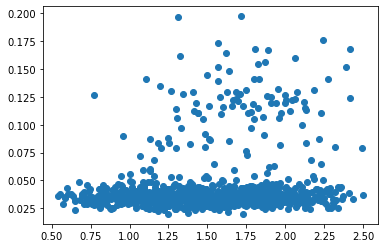

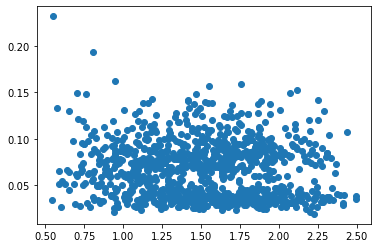

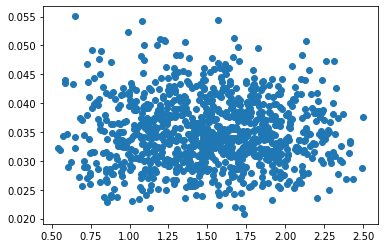

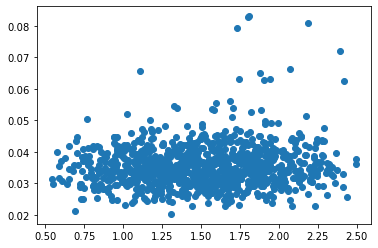

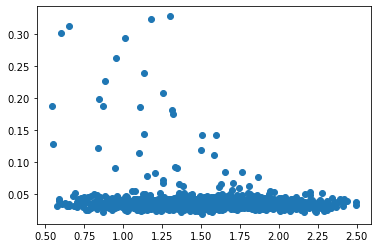

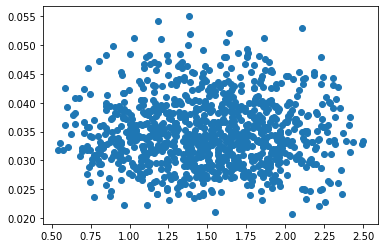

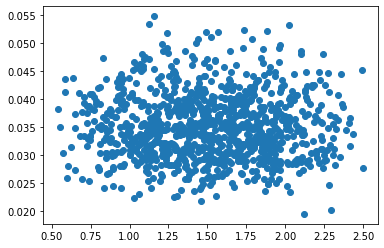

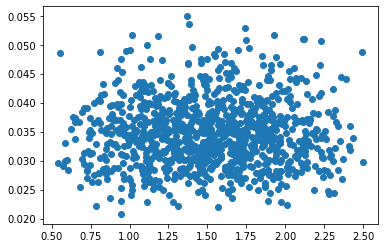

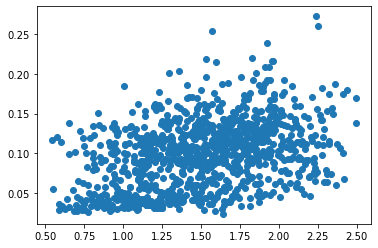

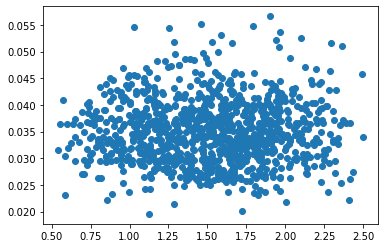

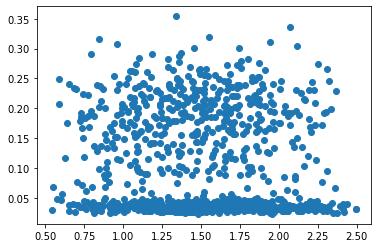

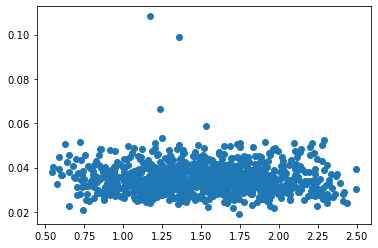

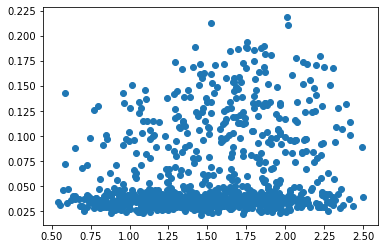

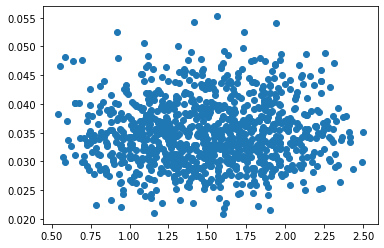

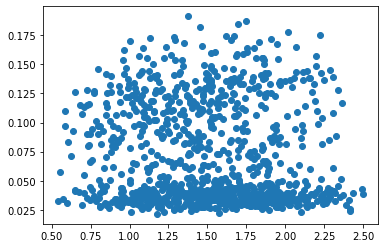

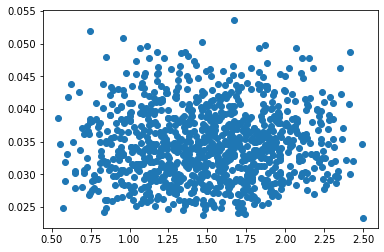

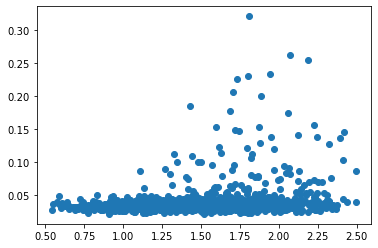

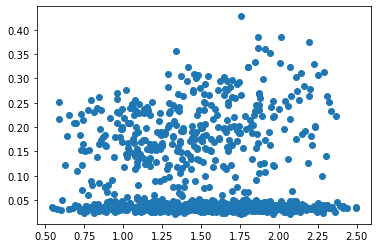

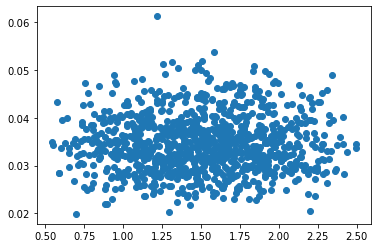

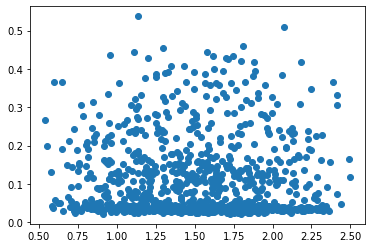

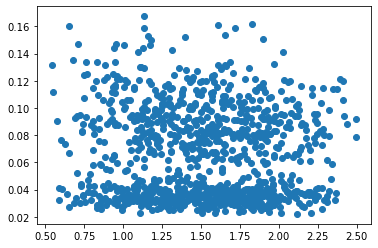

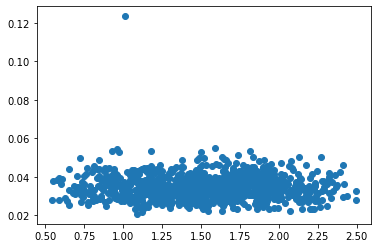

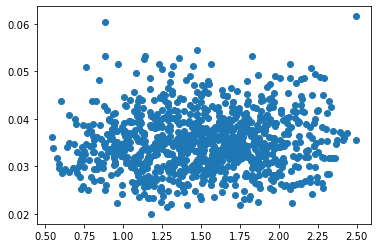

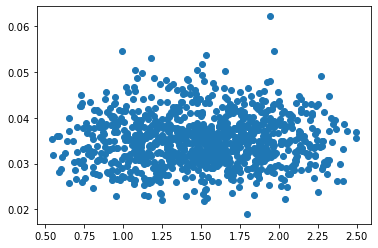

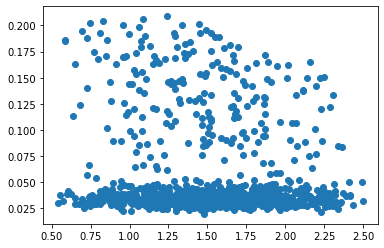

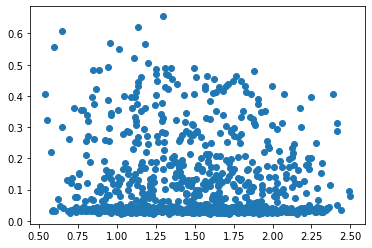

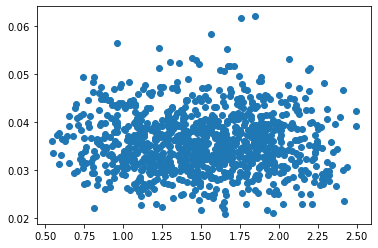

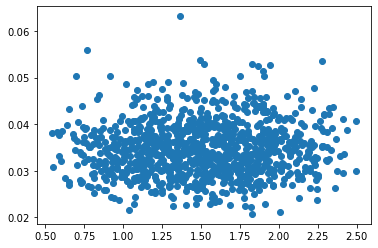

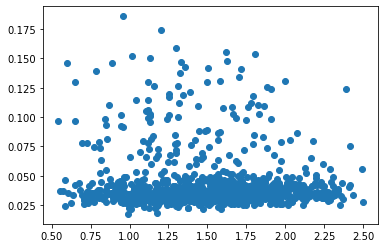

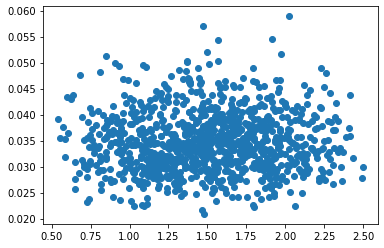

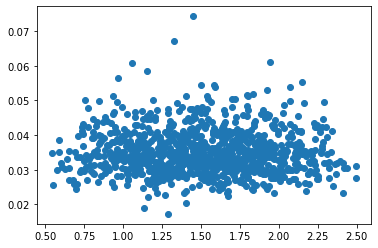

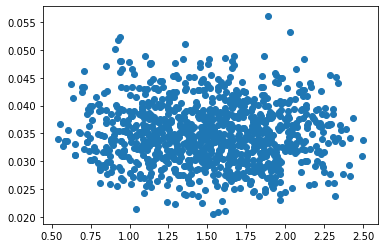

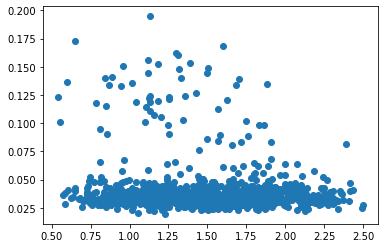

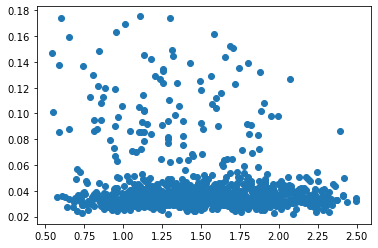

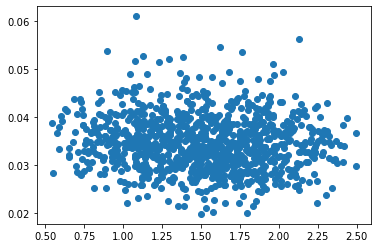

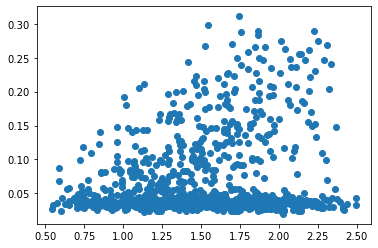

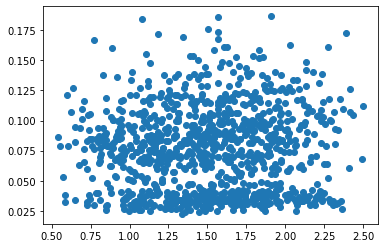

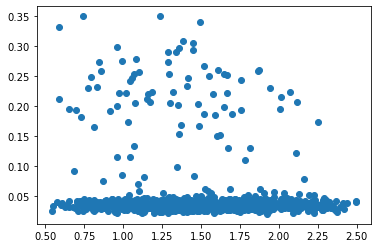

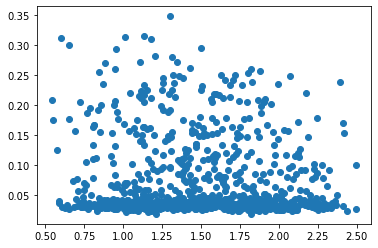

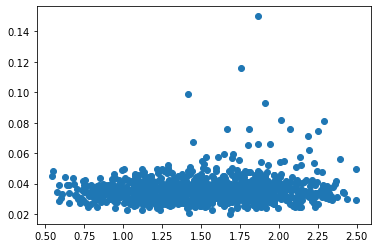

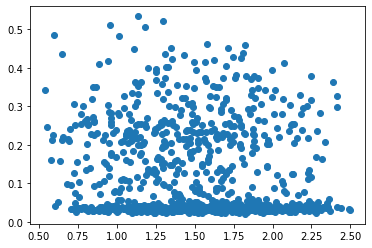

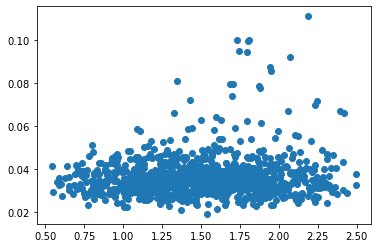

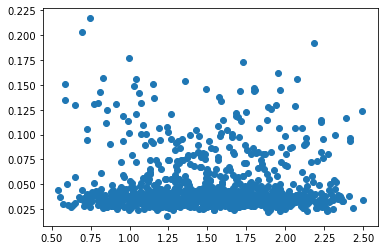

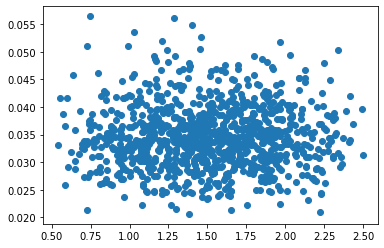

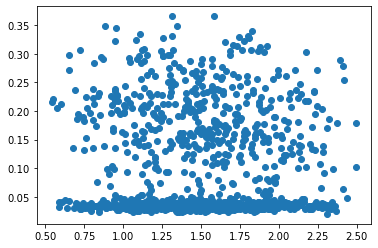

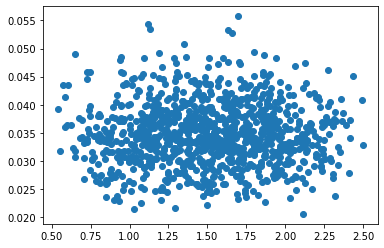

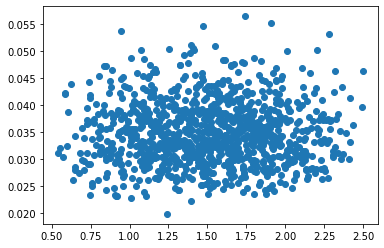

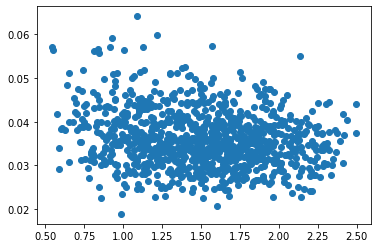

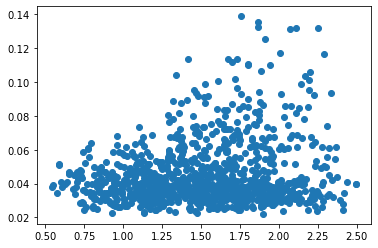

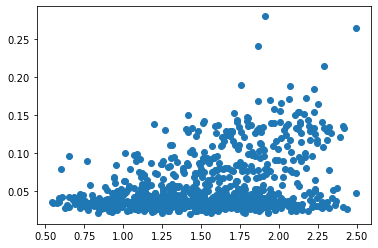

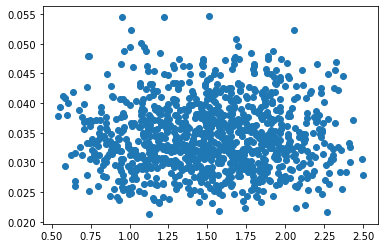

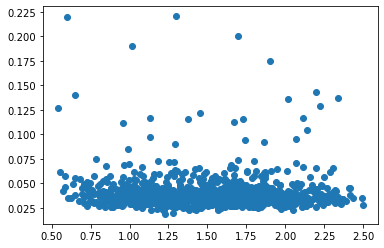

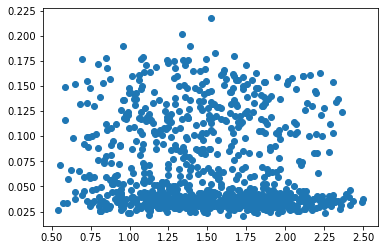

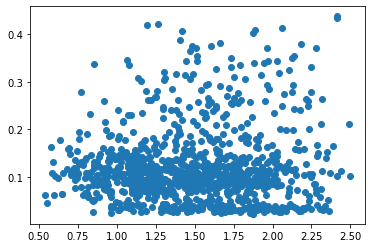

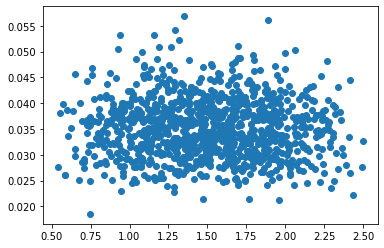

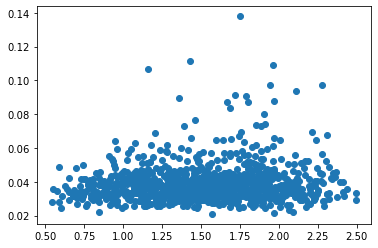

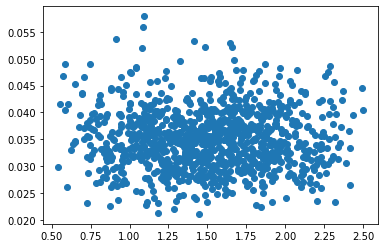

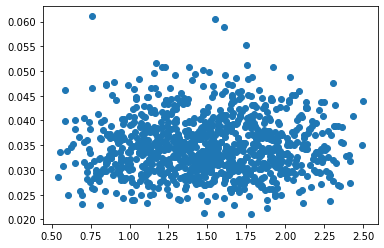

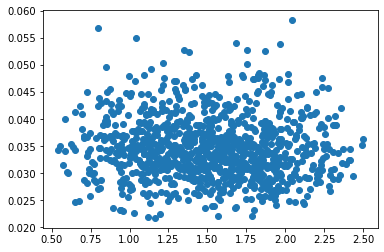

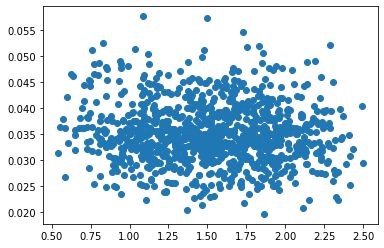

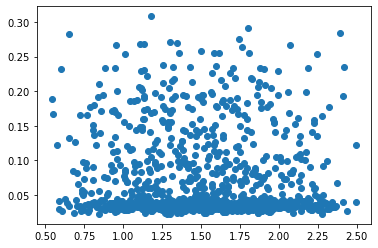

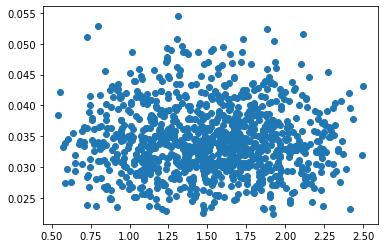

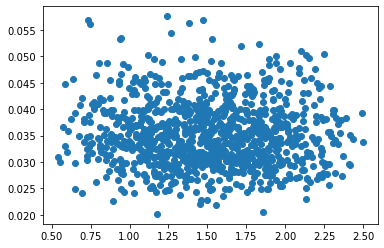

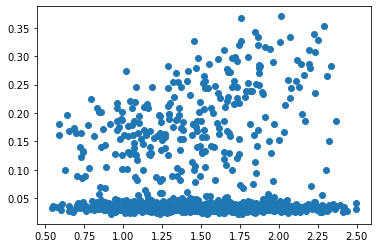

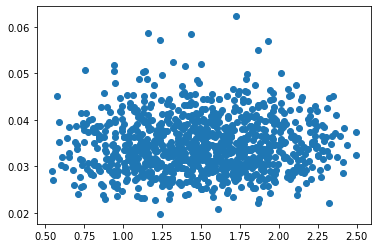

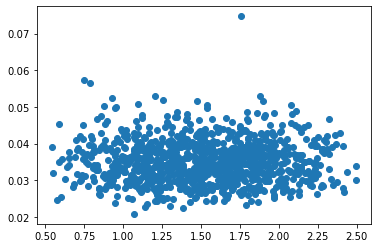

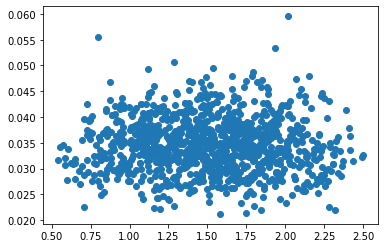

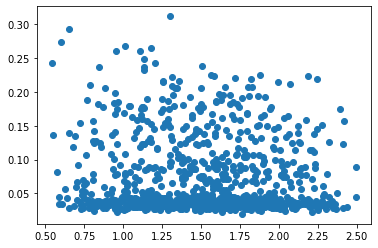

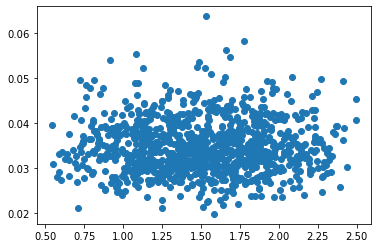

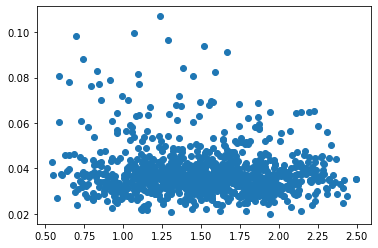

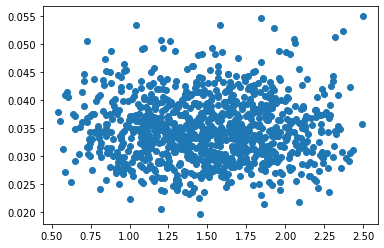

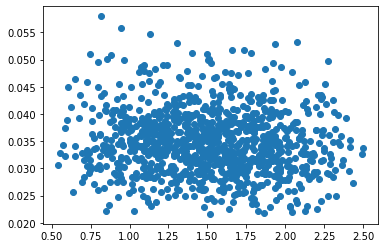

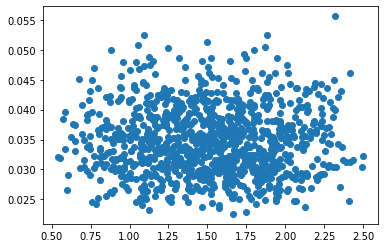

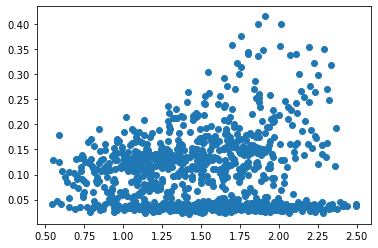

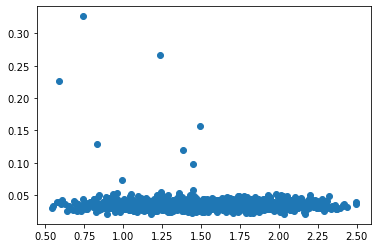

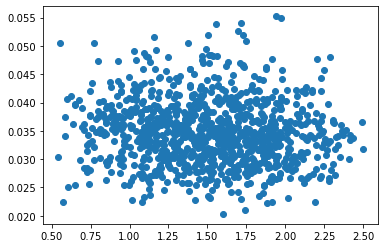

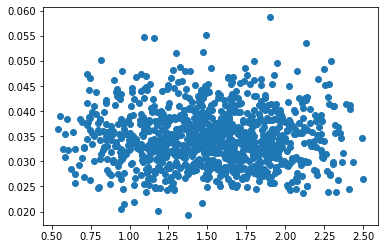

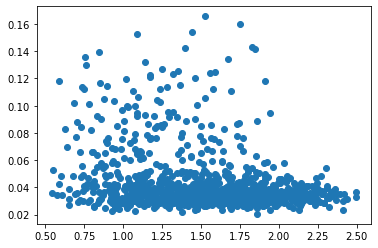

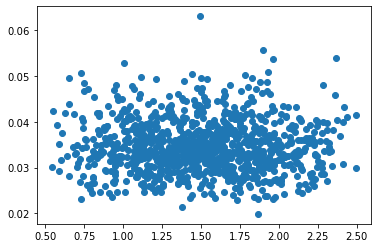

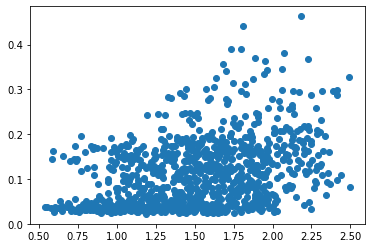

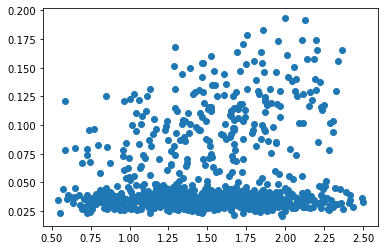

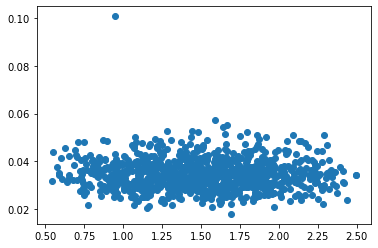

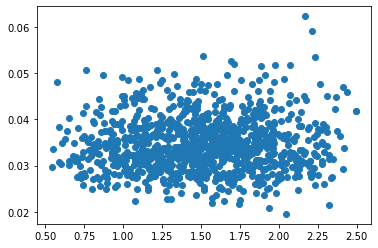

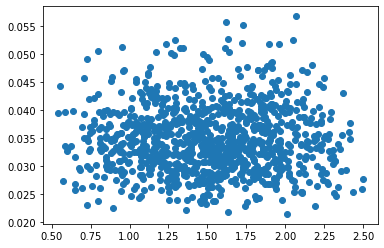

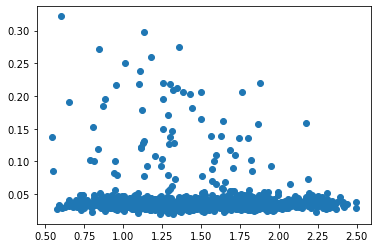

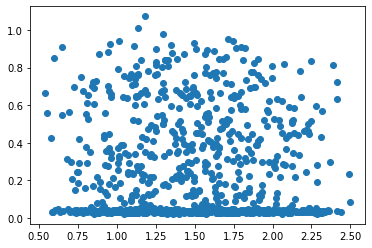

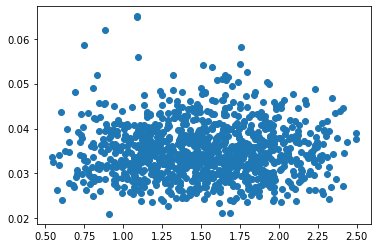

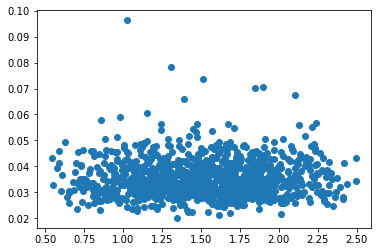

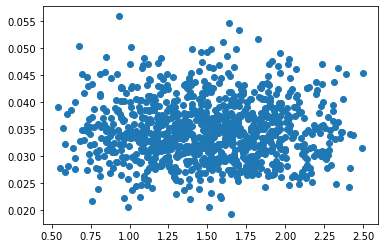

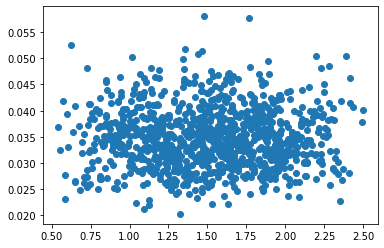

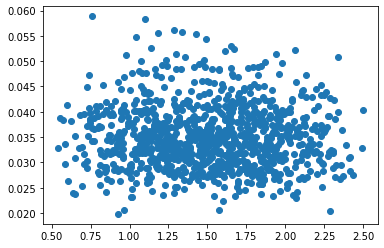

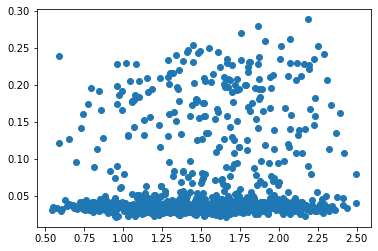

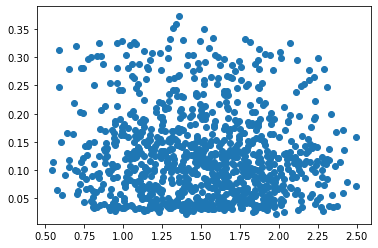

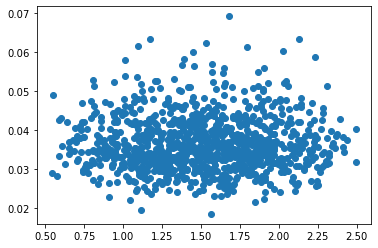

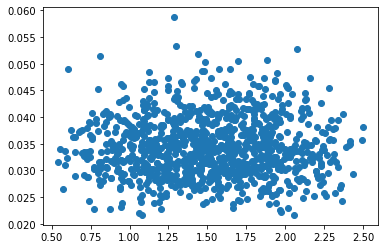

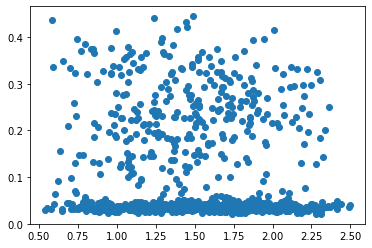

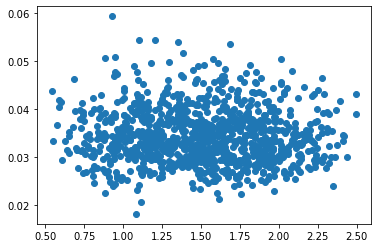

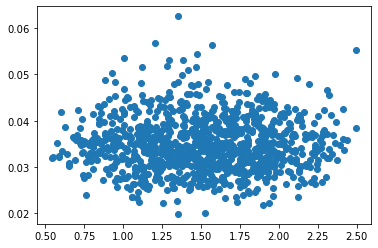

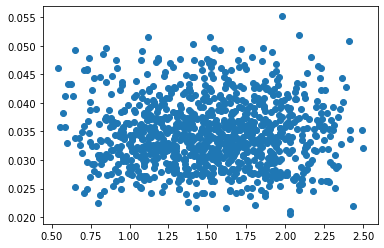

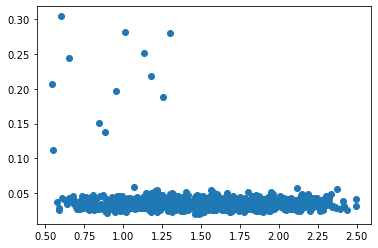

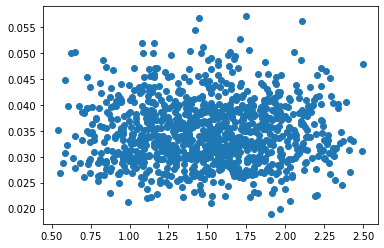

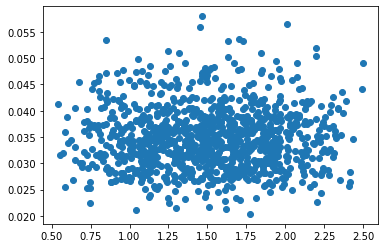

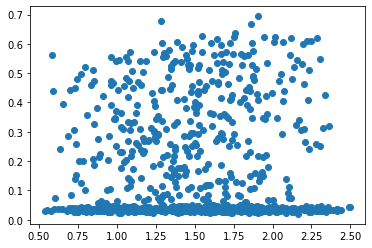

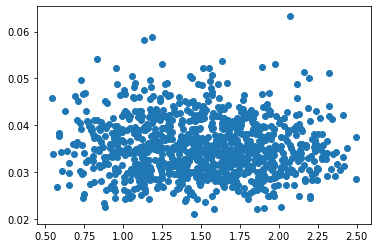

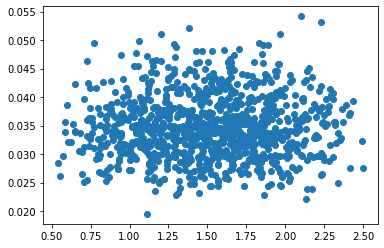

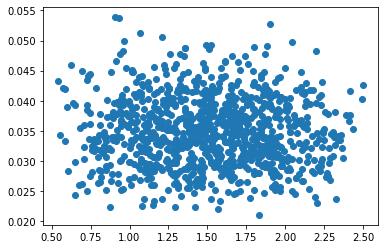

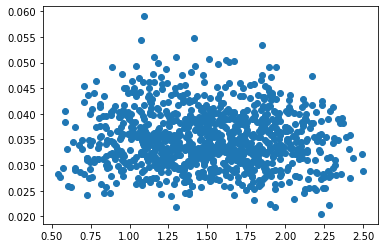

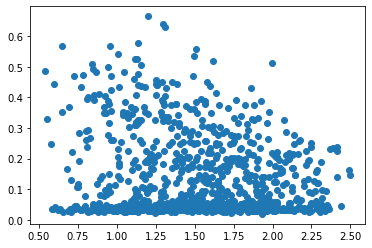

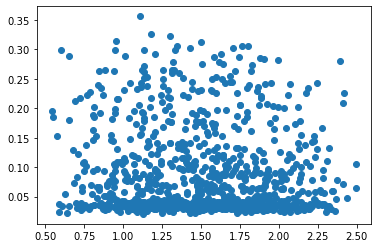

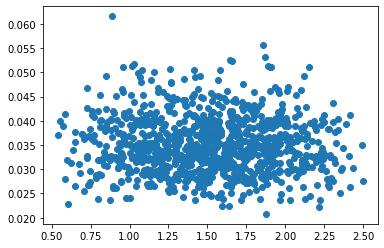

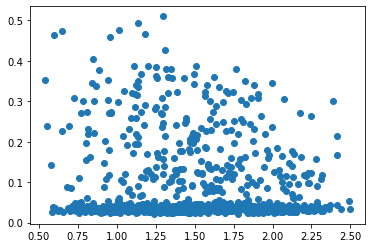

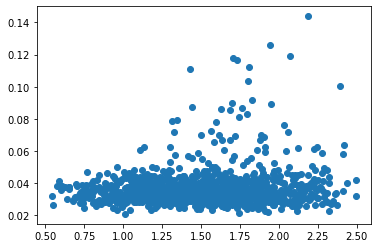

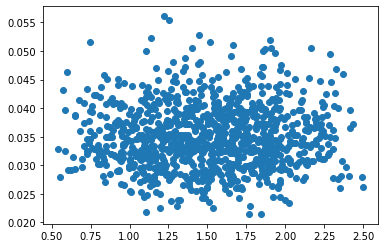

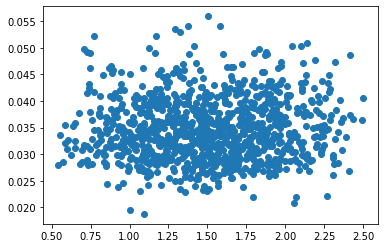

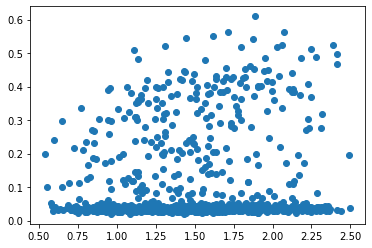

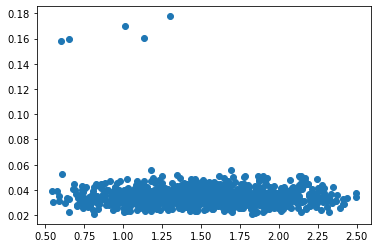

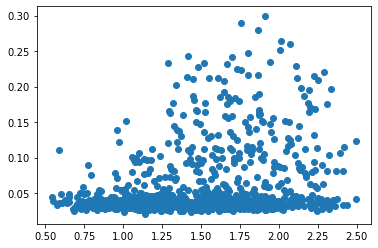

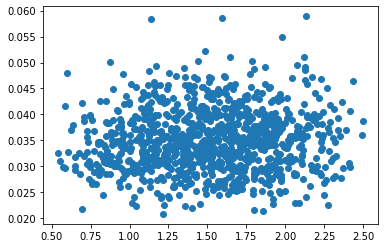

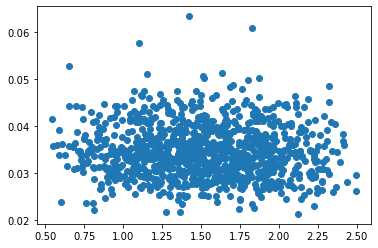

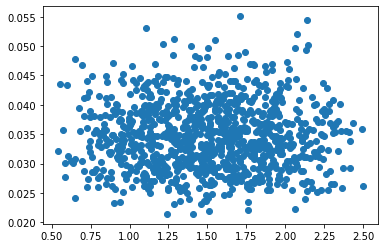

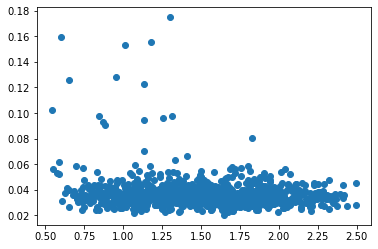

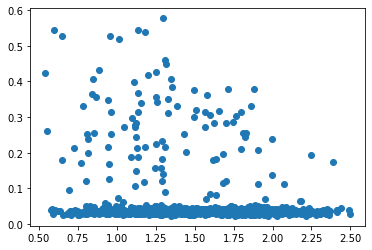

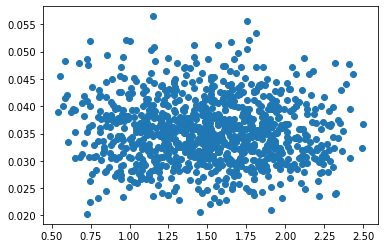

In [102]:
for i in range(200):
    plt.scatter(
        1 / np.array(sigma_post_list) ** 2, 
        np.std(neural_dynamics[:, :, i], axis=1),
    )
    plt.show()

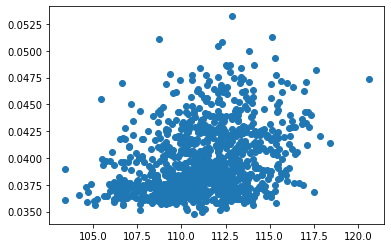

In [125]:
plt.scatter(
    np.mean(np.sum((neural_dynamics>0)[:, 20:, :], axis=2), axis=1),
    np.mean(np.std(neural_dynamics[:, 20:, :], axis=1), axis=1),
)
plt.show()

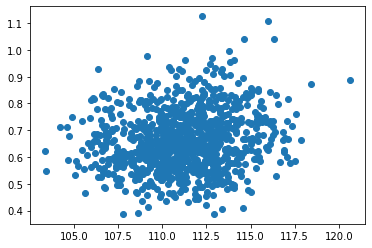

In [126]:
plt.scatter(
    np.mean(np.sum((neural_dynamics>0)[:, 20:, :], axis=2), axis=1),
    np.std(outputs.detach().numpy()[:, 20:, 0], axis=1),
)
plt.show()

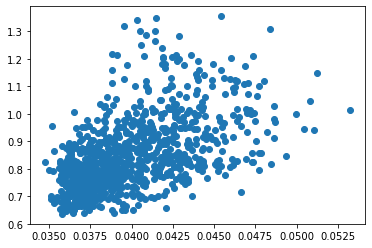

In [127]:
plt.scatter( 
    np.mean(np.std(neural_dynamics[:, 20:, :], axis=1), axis=1),
    sigma_post_list,
)
plt.show()

In [59]:
from scipy.stats import pearsonr

pearsonr(
    np.mean(np.sum((neural_dynamics>0)[:, 20:, :], axis=2), axis=1),
    sigma_post_list,
)

(0.24880373378551537, 1.4178055452489953e-15)

In [58]:
from scipy.stats import pearsonr

pearsonr(
    np.mean(np.sum((neural_dynamics>0)[:, 20:, :], axis=2), axis=1),
    np.std(outputs.detach().numpy()[:, 20:, 0], axis=1),
)

(-0.2081105032751517, 3.0179188970077526e-11)

In [22]:
from scipy.stats import norm

outputs_np = outputs.detach().numpy()[:, :, 0]
kl_div = 0
eps=1e-10
n = np.linspace(-20, 20, 40)
for i in range(sample_num):
    q = np.histogram(outputs_np[i], bins=40, range=(-20, 20))[0] / 60
    p = []
    for j in range(len(n)):
        p.append(norm.pdf(x=n[j], loc=mu_post_list[i], scale=sigma_post_list[i]))
        
    kl_div += np.sum([qi * np.log(qi / (pi + eps) + eps) for qi, pi in zip(q, p)])
    
print(kl_div / sample_num)

0.3425195823440037
